# STA 863 Final Project - FHMM
*Factorial Hidden Markov Models* - Gharamani and Jordan


In [90]:
import numpy as np
import pandas as pd
import csv
import time
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.stats import multivariate_normal
import seaborn as sns
from music_comp import * ## pre-processing and metrics code
np.random.seed(17)

In [2]:
# Calculate log likelihood
# n is number of observations
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations 
# mu is a D x n mean matrix
def log_like(n, pi, Tmat, mu, C, Y, zstates):
    y_prob = np.zeros(n) # emission probabilities
    t_prob = 0 # transition matrix probabilities
    pi_prob = 0 # initial probability
    for i in range(0, M):
            pi_prob += np.log(pi[i][zstates[i][0]])
    
    for t in range(0, n):
        y_prob[t] = np.log(multivariate_normal.pdf(Y[:, t], mean = mu[:, t], cov = C))  
        
        for i in range(0, M):
            t_prob += Tmat[i][zstates[i][t-1], zstates[i][t]]
    ll = pi_prob + t_prob + np.sum(y_prob)        
    return(ll)

## 1. Generate Toy Data and Parameters

$$P({S_t, Y_t}) = P(S_1)P(Y_1 | S_1)\prod_{t=2}^T P(S_t | S_{t-1})P(Y_t | S_t)$$

- Assume three different chains, each with 5 hidden states each
- M = 3, K = (5, 5, 5)
- n = 10 observations, D = 3 (dimension of Gaussian)
- Normal Model

In [3]:
# M = 3 ## Number of independent hidden state chains
# K = np.array([5, 5, 5]) ## number of hidden states for each chain
# D = 3 ## Dimension of Gaussian
# n = 10 ## number of observations


# ## Generate distribtions
# pi = [] ## initial distribution
# Tmat = []  ## transition distribution
# W = [] ## contribution to means matrices D x K
# for i in range(0, M):
#     vals = np.random.rand(K[i])
#     pi.append(vals/np.sum(vals))
#     vals1 = np.random.rand(K[i], K[i])
#     Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
#     W.append(10*np.random.rand(D, K[i]))
    
# ## Generate state variables
# S = []
# for i in range(0, M):
#     zstates = np.arange(0, K[i], dtype = int)
#     z = np.zeros(n, dtype = int)
#     zmat = np.zeros((K[i], n), dtype = int)
#     z[0] = np.random.choice(zstates, size = 1, p = pi[i])
#     zmat[z[0], 0] = 1
#     for j in range(1, n):
#         z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
#         zmat[z[j], j] = 1
#     S.append(zmat)
# #x = np.random.normal(size=D)
# #y = np.random.normal(size=D)
# #z = np.vstack((x, y))
# #C = np.cov(z.T) ## covariance matrix
# C = np.identity(D)
# mu = np.zeros((D, n))
# Y = np.zeros((D, n))
# for t in range(0, n):
#     for i in range(0, M):
#         mu[:, t] += np.dot(W[i], S[i][:, t])
#     Y[:, t] = np.random.multivariate_normal(mu[:, t], C, 1)


In [4]:
#C_new = np.dot((np.array([1, 2, 1] ) - np.array([0, 0.7, 0]))[np.newaxis].transpose(), 
#               (np.array([1, 2, 1] ) - np.array([0, 0.7, 0]))[np.newaxis])
#print(np.all(np.linalg.eigvals(C_new) > 0))
#C_new

In [5]:
# print("Pi")
# print(np.round(pi, 3))
# print("Tmat")
# print(np.round(Tmat, 3))
# print("W")
# print(np.round(W, 3))
# print("C")
# print(np.round(C, 3))
# print("Z states")
# print([np.where(S[0][:, t] == 1)[0][0] for t in range(n)])
# print([np.where(S[1][:, t] == 1)[0][0] for t in range(n)])
# print([np.where(S[2][:, t] == 1)[0][0] for t in range(n)])
# print('Log-Likelihood')
# zstore = [[np.where(S[0][:, t] == 1)[0][0] for t in range(n)], [np.where(S[1][:, t] == 1)[0][0] for t in range(n)],
#          [np.where(S[2][:, t] == 1)[0][0] for t in range(n)]]
# log_like(n, pi, Tmat, mu, C, Y, zstore)

In [6]:
# sns.heatmap(Y)
# plt.title("Toy Data Y Values")
# pass

# E - Step

## 2. Gibbs Sampling 

$$S_t^{(m)} \propto P(S_t^{(m)} | S_{t-1}^{(m)})P(S_{t+1}|S_t^{(m)})P(Y_t | S_t^{(1)}, \ldots, S_t^{(M)})$$

In [7]:
# Calculate transition matrix from a vector
# q is a vector from 0 to m different states
# return m x m transition matrix b
from collections import Counter
def trans_mat(q, m):
    b = np.zeros((m,m))
    for (x,y), c in Counter(zip(q, q[1:])).items():
        b[x, y] = c
    return(b)


# t is the time step to be updated
# y is the observed value at that time step
# M is the number of hidden Markov chains
# K is a vector of number of hidden states for each chain
# C is covariance matrix for emission distribution
# W is a list of M D x K matrix, columns contribution to mean of each state variable 
# S is a M long list of current states, each element of list is K[i] x n long (n number of observations)
# update is which of M chains to calculate emission probabilities for, for every K[i] possible values
# output is a K[update] vector of density of y for each possible value of S[update]
def y_density(t, y, M, K, S, C, W, update):
    ydense = np.zeros(K[update]) ## output density for each possible value of S[update]
    Stemp = S
    for i in range(0, K[update]):
        mu = 0
        Stemp[update][:, t] = 0
        Stemp[update][i, t] = 1 # state variable value to calculate probability for
        for j in range(0, M):
            mu += np.dot(W[j], Stemp[j][:, t])
        ydense[i] = multivariate_normal.pdf(y, mean = mu, cov = C)
    return(ydense)



# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# it is the number of iterations to run for the Gibbs Sampler
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10):
    # Randomly initialize state vectors
    small = 10E-5
    S = []
    zstates = []
    for i in range(0, M):
        s = np.zeros((K[i], n), dtype = int)
        ind = np.random.choice(range(0, K[i]), n)
        s[ind, range(0, n)] = 1
        zz = np.zeros((it, n), dtype = int)
        zz[0, :] = ind
        zstates.append(zz)
        S.append(s)
        
    for l in range(1, it):
        ## update one  chain at a time
        for i in range(0, M):
            ## step through each time point
            for t in range(0, n):
                ## select P(S_t | S_t-1)
                if t == 0:
                    tback = np.ones(K[i])
                else:
                    prev = zstates[i][l-1, t-1]
                    tback = Tmat[i][prev, :]
                ## select P(S_t+1 | S_t)
                if t == (n-1):
                    tfore = np.ones(K[i])
                else:
                    fore = zstates[i][l-1, t]
                    tfore = Tmat[i][fore, :]
                ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
                ydense = y_density(t, Y[:, t], M, K, S, C, W, i)
                
                ## Calculate probability for each state for S_t^i
                probvec = np.multiply(np.multiply(tback, tfore) , ydense)
                if np.sum(probvec) == 0: # check if all states have 0 probability
                    probvec = np.ones(len(probvec)) # reset to equal probs if so
                probvec = probvec/sum(probvec)
                ## sample state and update vector
                zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
                S[i][zstates[i][l, t], t] = 1
    
    ## Calculate expectations
    # <S_t^(m)>
    St = []
    Smm = []
    for i in range(0, M):
        uprobs = [np.unique(zstates[i][:, t], return_counts = True)[1]/it for t in range(0,n)] # calculate probs
        zmat = np.zeros((K[i], n))
        inds = [np.unique(zstates[i][:, t], return_counts = True)[0] for t in range(0,n)]
        for t in range(n):
            zmat[inds[t], t] += uprobs[t] + small
        #zmat = zmat/np.sum(zmat)
        St.append(zmat)
        # calculate trans mat
        Smm.append(np.stack([trans_mat(zstates[i][:, t], K[i])/(it-1) for t in range(0, n)], axis = 2))  
    
    
    
    # <S_t^(m)S_t^(n)>
    Snm = np.zeros((sum(K), sum(K), n))
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    s1 = np.zeros((K[i], K[i]))
                    mm = np.unique(zstates[i][:, t], return_counts = True)
                    s1[mm[0], mm[0]] = mm[1]/it
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = s1
                s2 = np.zeros((K[i], K[j]))
                for l in range(0, it):
                    s2[zstates[i][l, t], zstates[j][l, t]] += 1
                Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = s2/it
    
    return(St, Smm, Snm)

## 3. Completely Factorized VI

In [8]:
## KL divergence (to monitor convergence of approximation) - equation C.9
# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# Return KL divergence
def KL_factorized(n, M, K, Y, theta, pi, Tmat, W, C):
    term1 = 0
    term2 = 0
    term3 = 0
    term4 = 0
    term5 = 0
    term6 = 0
    term7 = 0
    small = 10E-10
    for t in range(n):
        term2 += np.dot(Y[:, t].transpose() , np.dot(np.linalg.inv(C), Y[:, t]))
        for i in range(M):
            term1 += np.dot(theta[i][:, t].transpose(), np.log(theta[i][:, t] + small))
            term3 += np.dot(np.dot(Y[:, t].transpose(), np.linalg.inv(C)), np.dot(W[i], theta[i][:, t]))
            for j in range(M):
                if i != j:
                    targ1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), W[j])
                    targ2 = np.dot(theta[j][:, t], theta[i][:, t].transpose())
                    term4 += np.trace(np.dot(targ1, targ2))
            
            term5 += np.trace(np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), 
                                     np.dot(W[i], np.diag(theta[i][:, t]))))
            if t > 0:
                term7 += np.trace(np.outer(theta[i][:, t-1], 
                                           np.dot(theta[i][:, t].transpose(), np.log(Tmat[i] + small))))
                
    for i in range(M):
        term6 += np.dot(theta[i][:, 0].transpose(), np.log(pi[i] + small))
        
    # Find normalizing constants
    
    KL = term1 + 0.5*(term2 - 2*term3 + term4 + term5) + term6 + term7
    return(KL)
    

In [9]:
# Softmax operator on input vector x
def softmax(x):
    y = x - np.max(x)
    return(np.exp(y)/np.sum(np.exp(y)))


# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# theta is a M long list of K[m] x n matrices from completely factorized VI approx
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# tol is the tolerance for convergence of the KL divergence to stop the iterations
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def factorized_VI(n, M, K, Y, pi, Tmat, W, C, tol):
    D = Y.shape[0]
    thetaOld = []
    thetaNew = []
    for i in range(M):
        vals1 = np.random.rand(K[i], n)
        thetaOld.append(vals1/np.sum(vals1, axis=0)[None, :])
        thetaNew.append(np.zeros((K[i], n)))

    KLOld = 10E10
    small = 10E-10
    convergence = 0
    iterations = 0
    criteria = 10E10
    maxit = 20 ## max number of iterations
    while(convergence == 0):
        for i in range(M):
            for t in range(n):
                ## Calculate Y tilde
                s1 = np.zeros((D, 1))
                for j in np.delete(np.arange(M), i):
                    s1 += np.dot(W[j], thetaOld[j][:, t])[np.newaxis].transpose()
                Ytilde = Y[:, t][np.newaxis].transpose() - s1
                ## Calculate delta term
                delta = np.dot(W[i].transpose(), np.dot(np.linalg.inv(C), W[i])).diagonal()
                ## Calculate first term
                term1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), Ytilde)
                term2 = delta[np.newaxis].transpose()/2
                if t > 0:
                    term3 = np.dot(np.log(Tmat[i] + small), thetaOld[i][:, t-1])[:, np.newaxis]
                else:
                    term3 = np.log(pi[i] + small)[np.newaxis].transpose()
                if t < n-1:
                    term4 = np.dot(np.log(Tmat[i] + small).transpose(), thetaOld[i][:, t+1])[np.newaxis].transpose()
                else:
                    term4 = np.zeros(K[i])[np.newaxis].transpose()
                ## Find sum
                sumterm = term1 - term2 + term3 + term4
                thetaNew[i][:, t] = softmax(sumterm).transpose()





        ## Check KL divergence



        #KLNew = KL_factorized(n, M, K, Y, thetaNew, pi, Tmat, W, C)
        #print(KLNew)
        #criteria = abs(KLOld - KLNew)
        if criteria < tol or iterations > maxit:
            convergence = 1
        #else:
        #    convergence = 0
        #    KLOld = KLNew
        #    thetaOld = thetaNew

        iterations += 1

    ## Find expectations
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    # Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
    # Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
    St = [np.zeros((K[i], n)) for i in range(M)]
    Smm = [np.zeros((K[i], K[i], n)) for i in range(M)]
    Snm = np.zeros((np.sum(K), np.sum(K), n))
    for i in range(M):
        for t in range(n):
            St[i][:, t] = thetaNew[i][:, t]
            if t == 0:
                Smm[i][:, :, t] = np.outer(pi[i], thetaNew[i][:, t])
            else:
                Smm[i][:, :, t] = np.outer(thetaNew[i][:, t-1], thetaNew[i][:, t])

    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = np.diag(thetaNew[i][:, t])
                else:
                    Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = np.outer(thetaNew[i][:, t], thetaNew[j][:, t])
                    
    return(St, Smm, Snm)

# 4. Structural VI

In [10]:
## Forward- Backward Algorithm
#Function using the log-sum-exp trick#
def logSumExp(a):
    if np.all(np.isinf(a)):
        return np.log(0)
    else:
        b = np.max(a)
        return(b + np.log(np.sum(np.exp(a-b))))


def pForwardFHMM(g):
    n, m = g.shape
    pXf = logSumExp(g[n-1,:])
    return(pXf)

    
def forwardAlgFHMM(n, m, pi, Tmat, phi):
    g = np.zeros((n,m))
    for i in range(0,m):
        g[0,i] = (pi[i]) + (phi[i, 0])
    
    
    for j in range(1, n):
        for l in range(0, m):
            g[j,l] = logSumExp(np.asarray(g[j-1, :]) + np.asarray(Tmat[:,l]) + (phi[l, j]))
    return(g)

def backwardAlgFHMM(n, m, pi, Tmat, phi):
    r = np.zeros((n,m))
    for j in range(n-2, -1, -1):
        for l in range(0, m):
            r[j, l] = logSumExp(np.asarray(r[j+1,: ]) + np.asarray(Tmat[l,:]) + phi[:, j+1])
    
    return(r)

In [11]:
# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# theta is a M long list of K[m] x n matrices from completely factorized VI approx
# pi is M long list of initial distributions
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# tol is the tolerance for convergence of the KL divergence to stop the iterations
# output is:
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
def structural_VI(n, M, K, Y, pi, Tmat, W, C, tol):
    D = Y.shape[0]
    small = 10E-10
    ## Work with log of parameters
    piL = [np.log(pi[i] + small) for i in range(M)]
    TmatL = [np.log(Tmat[i] + small) for i in range(M)]
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    St = [np.zeros((K[i], n)) for i in range(M)]
    ## h matrices which serve as emission distributions for forward-backward
    phi = [np.zeros(shape = (K[i], n)) for i in range(M)]
    ## Randomly initialize St
    for i in range(M):   
        vals = np.random.rand(K[0], n)
        St[i] = vals/np.sum(vals, axis=0)[None, :]
    
    
    pOld = 10E10#*np.ones(M)
    pNew = np.zeros(M)
    convergence = 0
    iterations = 0
    criteria = 10E10
    maxit = 20 ## max number of iterations
    while(convergence == 0):
        for i in range(M):
            ## 1. Find ht = phi ##

            ## Calculate delta term
            delta = np.dot(W[i].transpose(), np.dot(np.linalg.inv(C), W[i])).diagonal()

            for t in range(n):
                ## Calculate Y tilde
                s1 = np.zeros((D, 1))
                for j in np.delete(np.arange(M), i):
                    s1 += np.dot(W[j], St[j][:, t])[np.newaxis].transpose()
                Ytilde = Y[:, t][np.newaxis].transpose() - s1
                term1 = np.dot(np.dot(W[i].transpose(), np.linalg.inv(C)), Ytilde)
                term2 = delta[np.newaxis].transpose()/2
                #phi[i][:, t] = np.exp(term1 - term2).transpose()
                phi[i][:, t] = (term1 - term2).transpose()


            ## 2. Run Forwards-Backwards Algorithm

            g = forwardAlgFHMM(n, K[i], piL[i], TmatL[i], phi[i])
            h = backwardAlgFHMM(n, K[i], piL[i], TmatL[i], phi[i])
            pNew[i] = pForwardFHMM(g)
            #print(g)
            #print(pForward(g))

            ## 3. Update expectations
            for t in range(0, n):
                for j in range(0, K[i]):
                    St[i][j, t] = np.exp(g[t, j] + h[t, j] - pNew[i])
                    
            #print(np.sum(St[i]))
        ## Check log-likelihood
        #print(KLNew)
        #print(pOld)
        #print(pNew)
        criteria = abs(pOld - np.max(pNew))
        if criteria < tol or iterations > maxit:
            convergence = 1
        else:
            convergence = 0
            pOld = np.max(pNew)
            #thetaOld = thetaNew

        iterations += 1




    
    ## Find expectations
    # St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
    # Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
    # Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
    
    ## St already found above
    Smm = [np.zeros((K[i], K[i], n)) for i in range(M)]
    for i in range(M):
        for t in range(n):
            if t == 0:
                Smm[i][:, :, t] = np.outer(pi[i], St[i][:, t])
            else:
                Smm[i][:, :, t] = np.outer(St[i][:, t-1], St[i][:, t])
    
    #intermed = Smm[m][:, :, t]/np.sum(Smm[m][:, :, t])
    #Smm[m][:, :, t] = np.exp(intermed)/np.sum(np.exp(intermed)) ## renormalize
    
#     for m in range(M):
#         for t in range(0, n):
#             for i in range(0, K[m]):
#                 for j in range(0, K[m]):
#                     if t == 0:
#                         #Smm[m][i, j, t] = np.exp(TmatL[m][i,j] + phi[m][j, t] + piL[m][i] + h[t, j] - pNew[m])
#                         Smm[m][i, j, t] = TmatL[m][i,j] + phi[m][j, t] + piL[m][i] + h[t, j] - pNew[m]
#                     else:
#                         #Smm[m][i, j, t] = np.exp(TmatL[m][i,j] + phi[m][j, t] + g[t-1, i] + h[t, j] - pNew[m])
#                         Smm[m][i, j, t] = TmatL[m][i,j] + phi[m][j, t] + g[t-1, i] + h[t, j] - pNew[m]
            
#             #print(np.sum(Smm[m][:, :, t]))
#             if np.sum(Smm[m][:, :, t]) < small:
#                 Smm[m][:, :, t] += small
            
#             intermed = Smm[m][:, :, t]/np.sum(Smm[m][:, :, t])
#             Smm[m][:, :, t] = np.exp(intermed)/np.sum(np.exp(intermed)) ## renormalize
    
    
    Snm = np.zeros((np.sum(K), np.sum(K), n))
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0) # indices for Snm matrix
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for t in range(0, n):
        for i in range(0, M):
            for j in range(0, M):
                if i == j:
                    Snm[ind1[i]:ind2[i], ind1[i]:ind2[i], t] = np.diag(St[i][:, t])
                else: ## Assume independence
                    Snm[ind1[i]:ind2[i], ind1[j]:ind2[j], t] = np.outer(St[i][:, t], St[j][:, t])
                    
    return(St, Smm, Snm)

In [12]:
# import warnings

# # warnings.simplefilter("always")
# # for i in range(10):
# #     print i
# #     warnings.warn('this is a warning message')
# warnings.simplefilter('error')
# for i in range(100):
#     print(i)
#     St, Smm, Snm = structural_VI(n, M, K, Y, pi, Tmat, W, C_new, tol = 1E-5)
#     W, pi, Tmat, C_new = Mstep(M, K,  Y, St, Smm, Snm)
#     if not np.all(np.linalg.eigvals(C_new) > 0):
#         print(C_new)
#         break
#     #print(np.all(np.linalg.eigvals(C_new) > 0))

### Check

In [13]:
#for i in range(M):
#    print(np.sum(St[i], axis = 0))
#    for t in range(n):
#        print(np.sum(Smm[i][:,:,  t]))
#        print(np.sum(St[i][:, t]))
#for t in range(n):
#    print(np.sum(Snm[0:5, 0:5, t]), np.sum(Snm[0:5, 5:10, t]), np.sum(Snm[0:5, 10:15, t]))
#    print(np.sum(Snm[5:10, 0:5, t]), np.sum(Snm[5:10, 5:10, t]), np.sum(Snm[5:10, 10:15, t]))
#    print(np.sum(Snm[10:15, 10:15, t]), np.sum(Snm[10:15, 10:15, t]), np.sum(Snm[10:15, 10:15, t]))
    

# M-Step

## 5. M-Step

$$ n = T$$
$$W^{new} = \left(\sum_{t=1}^T Y_t<S_t'>\right)\left(\sum_{t=1}^T<S_tS_t'>\right)^{\dagger}$$

** Add other update equations **

In [14]:
# M is number of hidden state Markov chains
# K is vector of number of hidden states for each Markov chain
# Y is the D x n matrix of observations
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t-1^(m)S_t^(m)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
# output is a tuple of updated values from the M step
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations

def Mstep(M, K,  Y, St, Smm, Snm):
    D, n = Y.shape
    ### Update W ###
    # Concatenate St to be sum(K) x 1 x t
    cSt = np.vstack([np.vstack(St[i]) for i in range(0, len(St))])
    s1 = np.dot(Y, cSt.transpose()) # first sum for Wnew
    s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
    Wnew = np.dot(s1, s2)
    # make Wnew back into list of matrices
    W = []
    pi = []
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0)
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for i in range(0, M):
        W.append(Wnew[:, ind1[i]:ind2[i]])
        ### Update pi ###
        pi.append(cSt[ind1[i]:ind2[i], 0])

    ### Update Transition matrices ###
    Tmat = []
    #St = [np.vstack(St[i]) for i in range(0, M)] ## stack St matrices for easier indexing
    for i in range(0, M):
        Tnew = np.zeros((K[i], K[i]))
        for j in range(0, K[i]):
            for l in range(0, K[i]):
                Tnew[j,l] =  np.sum(Smm[i][j, l, :])/np.max([np.sum(St[i][l, 0:(n-1)]), 10E-5])
        #print(np.sum(Tnew, axis=1)[:,None])
        if np.any(np.sum(Tnew, axis=1)[:,None]):
            #print("Yes")
            Tnew = Tnew + 10E-5
        #print(np.sum(Tnew, axis=1)[:,None])
        Tnew = Tnew/np.sum(Tnew, axis=1)[:,None]
        Tmat.append(Tnew)

    ### Update C covariance ###
    #s1 = np.dot(Y, Y.transpose())/n
    #s2 = np.zeros((D, D))
    #for t in range(0, n):
    #    for i in range(0, M):
    #        mult1 = np.dot(W[i], St[i][t, :])
    #        s2 += np.outer(mult1, Y[:, t].transpose())
    #C = s1 - s2/n
    
    #mutemp = np.zeros((D, n))
    #for i in range(0, M):
    #    mutemp += np.dot(W[i], np.vstack(St[i]))
    #C = np.dot(Y - mutemp, (Y - mutemp).transpose())/n
    
    term2 = np.zeros((D, D))
    for i in range(M):
        for t in range(n):
            term2 += np.dot(np.dot(W[i], St[i][:, t][:, np.newaxis]), Y[:, t][np.newaxis])


    C = np.dot(Y, Y.transpose())/n - term2/n
    
    return(W, pi, Tmat, C)

# 6. Inference: Run E-M Steps

In [46]:
# Y is D x n observation matrix
# M is number of hidden markov chains
# K is an 1 x M vector of the number of hidden states for each chain
# tol = tolerance for convergence
# inference is inference method to use, choices = Gibbs, FactorizedVI, StructuralVI
def FHMM(Y, M, K, tol, inference):
    D, n = Y.shape
    print(D, n)
    ## Initialize params
    pi = [] ## initial distribution
    Tmat = []  ## transition distribution
    W = [] ## contribution to means matrices D x K
    for i in range(0, M):
        vals = np.random.rand(K[i])
        pi.append(vals/np.sum(vals))
        vals1 = np.random.rand(K[i], K[i])
        Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
        W.append(10*np.random.rand(D, K[i]))
    C_old = np.identity(D)
    print(C_old)
    convergence = 0
    pOld = 10E10
    iterations = 0
    while(convergence == 0):
        
        ## E - Step
        if inference == "Gibbs":
            St, Smm, Snm = gibbs_sampler(n, M, K, Y, Tmat, W, C_old, it = 10)
            
        if inference == "FactorizedVI":
            St, Smm, Snm = factorized_VI(n, M, K, Y, pi, Tmat, W, C_old, tol = 1E-5)
            
        if inference == "StructuralVI":
            St, Smm, Snm = structural_VI(n, M, K, Y, pi, Tmat, W, C_old, tol = 1E-5)
        
        ## M - Step
        W, pi, Tmat, C_new = Mstep(M, K,  Y, St, Smm, Snm)
        pi = [pi[i]/np.sum(pi[i]) for i in range(M)]
        
        
        
        ## Check tolerance
        # sample S with new params
        ## Generate state variables
        #S = []
        #mu = np.zeros((D, n))
        #zstore = []
        #for i in range(0, M):
        #    zstates = np.arange(0, K[i], dtype = int)
        #    z = np.zeros(n, dtype = int)
        #    zmat = np.zeros((K[i], n), dtype = int)
        #    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
        #    zmat[z[0], 0] = 1
        #    for j in range(1, n):
        #        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        #        zmat[z[j], j] = 1
        #    S.append(zmat)
        #    zstore.append(z)
        #for i in range(0, M):
        #    for j in range(1, n):
        #        mu[:, j] += np.dot(W[i], S[i][:, j])
        
        #pNew = log_like(n, pi, Tmat, mu, C, Y, zstore) 
        
        
        ## Monitor convergence of C since does not have label switching issues like other params
        criteria = np.linalg.norm(C_old - C_new)
        #criteria = abs(pOld - pNew)
        if criteria < tol or iterations > 500:
            convergence = 1
        else:
            convergence = 0
            #pOld = pNew
            C_old = C_new
    
        iterations += 1
        if iterations%10 == 0:
            print(iterations)
            print(criteria)
            
    if not np.all(np.linalg.eigvals(C_new) > 0):
           C_new = np.dot(C_new.transpose(), C_new)
    return(iterations, pi, Tmat, C_new, W)
                    

In [16]:
# pi_new, Tmat_new, mu_new, C_new, W_new = FHMM(Y, M, K, 0.1, "FactorizedVI")
# print(C_new)
# np.all(np.linalg.eigvals(C_new) > 0)

# Generate New Data

In [17]:
def new_sequence(n, D, M, K, pi, Tmat, C, W):
    ## Generate state variables
    S = []
    for i in range(0, M):
        zstates = np.arange(0, K[i], dtype = int)
        z = np.zeros(n, dtype = int)
        zmat = np.zeros((K[i], n), dtype = int)
        z[0] = np.random.choice(zstates, size = 1, p = pi[i])
        zmat[z[0], 0] = 1
        for j in range(1, n):
            z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
            zmat[z[j], j] = 1
        S.append(zmat)
    mu = np.zeros((D, n))
    Y = np.zeros((D, n))
    for t in range(0, n):
        for i in range(0, M):
            mu[:, t] += np.dot(W[i], S[i][:, t])
        Y[:, t] = np.random.multivariate_normal(mu[:, t], C, 1)
    return(Y)

In [18]:
# new_sequence(n, D, M, K, pi_new, Tmat_new, C_new, W_new)

# Generalized Additive Models

Assumes univariate distributions

In [19]:
# from scipy.stats import norm
# norm.logpdf(Y, loc = np.zeros(3), scale = np.ones(3))
# np.ones(3)*(5*np.ones(3))

In [20]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

# mu, Sigma vectors of params for each possible value of hidden states each is 1 x K[i]
# make emission distribution matrix for normal case
# X is D x n
def make_phi(n, m, mu, Sigma, X):
    phi = np.zeros((m, n))
    for i in range(m):
        #phi[i, :] = multivariate_normal.logpdf(X.transpose(), mean = mu[i], cov = Sigma[i])
        phi[i, :] = norm.logpdf(X, loc = mu[i], scale = Sigma[i]) ## need standard dev
    return(phi)




def forwardAlgGAM(n, m, pi, Tmat, phi):
    g = np.zeros((n,m))
    for i in range(0,m):
        g[0,i] = (pi[i]) + (phi[i, 0])
    
    for j in range(1, n):
        for l in range(0, m):
            g[j,l] = logSumExp(np.asarray(g[j-1, :]) + np.asarray(Tmat[:,l]) + (phi[l, j]))
    return(g)

def backwardAlgGAM(n, m, pi, Tmat, phi):
    r = np.zeros((n,m))
    for j in range(n-2, -1, -1):
        for l in range(0, m):
            r[j, l] = logSumExp(np.asarray(r[j+1,: ]) + np.asarray(Tmat[l,:]) + phi[:, j+1])
    return(r)

def ViterbiGAM(n, m, pi, Tmat, phi, x):
    f = np.zeros(shape = (n,m))
    alpha = np.zeros(shape = (n,m))
    zStar = np.zeros(n)
    
    for t in range(0, n):
        for i in range(0,m):
            if t == 0:
                f[0, i] = pi[i] + phi[i, 0]
            else:
                u = np.asarray(f[t-1, :]) + np.asarray(Tmat[:, i]) + phi[i, t]
                f[t,i] = np.max(u)
                alpha[t,i] = np.argmax(u)
    zStar[n-1] = np.argmax(np.asarray(f[n-1, :]))
    for i in range(n-2, -1, -1):
        zStar[i] = alpha[i+1, int(zStar[i+1])]
    return zStar

## method = type of expectation to find, choices are "gamma" and "V", see paper pg. 2428
def first_orderGAM(n, m, x, w, tol, method):
    #randomly initialize pi, phi and T#
    vals = np.random.rand(m)
    pi = np.log(vals/np.sum(vals))
    Tmat = np.zeros(shape = (m, m))
    mu = np.zeros(m)
    Sigma = np.ones(m)
    phi = make_phi(n, m, mu, Sigma, x)
    gamma = np.zeros(shape = (n, m))
    beta = np.zeros(shape = (n,m,m))
    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pNew = 0
    criteria = 0
    
    vals1 = np.random.rand(m,m)
    Tmat = np.log(vals1/np.sum(vals1, axis=1)[:,None])
    
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        #Perform forward and backward algorithms# 
        g = forwardAlgGAM(n, m, pi, Tmat, phi)
        h = backwardAlgGAM(n, m, pi, Tmat, phi)
        pNew = pForwardFHMM(g)
        
        ##E-Step##
    
        #Calculate gamma and beta#
        for t in range(0, n):
            for i in range(0,m):
                gamma[t,i] = g[t,i] + h[t,i] - pNew
        #p = np.full((n,m), pNew)
        #gamma = g+h-p
        for t in range(1, n):
            for i in range(0, m):
                for j in range(0, m):
                    beta[t,i,j] = Tmat[i,j] + phi[j, t] + g[t-1, i] + h[t, j] - pNew
        ##M-Step##
    
        #Update pi, phi and Tmat#
        pi = gamma[0,:] - logSumExp(gamma[0,:])
        for i in range(0, m):
            for j in range(0, m):
                Tmat[i,j] = logSumExp(beta[1::, i, j]) - logSumExp(beta[1::, i,:])
        
        
        ## Update mu, Sigma
        for i in range(0, m):
            mu[i] = np.sum(np.exp(gamma[:, i])*w*x)/np.sum(np.exp(gamma[:, i])*w)
            Sigma[i] = np.sum(np.exp(gamma[:, i])*w*(x - mu[i])**2)/np.sum(np.exp(gamma[:, i])*w)
            
        # Update phi
#         Sigma = np.sqrt(Sigma)
#         for i in range(m):
#             if Sigma[i] == 0 or iterations == 1:
#                 print(np.exp(phi))
#                 print(g)
#                 print(h)
#                 print(pNew)
#                 print(Sigma)
#                 print(gamma[:, i])
#                 print(np.sum(np.exp(gamma[:, i])*w*(x - mu[i])**2))
#                 print(np.sum((x - mu[i])**2))
#                 print(np.sum(np.exp(gamma[:, i])*w))
#                 print(mu[i])
#                 print("\n")
        phi = make_phi(n, m, mu, Sigma, x)
        
        
        criteria = abs(pOld - pNew)
        if criteria < tol:
            convergence = 1
        
        elif iterations > 10:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
            iterations +=1
            #print(iterations)
            
    if method == "gamma":
        expect = gamma.transpose()
    if method == "V":
        most_likely = ViterbiGAM(n, m, np.exp(pi), np.exp(Tmat), np.exp(phi), x) ## Viterbi
        # Use one-hot encoding
        expect = np.zeros((m, n))
        for t in range(n):
            expect[int(most_likely[t]), t] = 1
    return (iterations, pNew, np.exp(pi), np.exp(phi), np.exp(Tmat), mu, Sigma, expect)

In [21]:
# w = np.ones(n)
# tol = 1E-3
# iterations, pNew, pi, phi, Tmat, mu, Sigma, expect = first_order(n, K[0], Y[0, :], w, tol, "V")
# #Viterbi(n, K[0], pi, Tmat, phi, Y[0, :])
# expect

In [45]:
# Y is D x n observation matrix
# M is number of hidden markov chains
# K is an 1 x M vector of the number of hidden states for each chain
# tol = tolerance for convergence
# method is type of expectation to find, choices are "gamma" and "V"
# inference is type of observed data, choices = Gaussian
def GAM_FHMM(x, M, K, tol, inference, method):
    n = len(x)
    ## Initialize params
    pi = [np.zeros(K[i]) for i in range(M)] ## initial distribution
    Tmat = [np.ones((K[i], K[i])) for i in range(M)]  ## transition distribution
    mu = [np.ones(K[i]) for i in range(M)] ## contribution to means, initially 0 for all chains
    Sigma = [np.ones(K[i]) for i in range(M)] ## variance for emission distributions, initially one for all chains
    W = [np.random.rand(n) for i in range(M)] ## weights for GAM
    expect = [np.ones((K[i], n)) for i in range(M)] ## expected values for f updates
    phi = [make_phi(n, K[i], mu[i], Sigma[i], x) for i in range(M)]
    convergence = 0
    pOld = 10E10
    iterations = 0
    output = np.zeros((M, n))
    while(convergence == 0):
        
        ## E - Step
        for i in range(M):
            if inference == "Gaussian":
                W = [np.ones(n) for i in range(M)]
                err = np.zeros(n)
                for t in range(n):
                    sterm = 0
                    for j in np.delete(np.arange(M), i):
                        sterm += np.dot(mu[j], expect[j][:, t])

                    err[t] = x[t] - sterm
#                     output[i, t] = err[t]
                _, pNew, pi[i], phi[i], Tmat[i], mu[i], Sigma[i], expect[i] = first_orderGAM(n, K[i], 
                                                                                          err, W[i], tol, method)
                Sigma[i] = np.sqrt(Sigma[i])
                #print(err)
            
        ## Check tolerance
        
        
        ## Monitor convergence of C since does not have label switching issues like other params
        criteria = abs(pOld - pNew)
        if criteria < tol or iterations > 500:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
    
        iterations += 1
        if iterations%10 == 0:
            print(iterations)
            print(criteria)
            
    return(iterations, pi, Tmat, phi, mu, Sigma)
                    

In [23]:
# pi, Tmat, phi, mu, Sigma = GAM_FHMM(Y[0, :], M, K, 1E-2, "Gaussian", "V")

In [24]:
def new_GAM(n, M, K, pi, Tmat, mu, Sigma):
    ## Generate state variables
    S = []
    for i in range(0, M):
        zstates = np.arange(0, K[i], dtype = int)
        z = np.zeros(n, dtype = int)
        zmat = np.zeros((K[i], n), dtype = int)
        z[0] = np.random.choice(zstates, size = 1, p = pi[i])
        zmat[z[0], 0] = 1
        for j in range(1, n):
            z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
            zmat[z[j], j] = 1
        S.append(zmat)
    Y = np.zeros(n)
    for t in range(0, n):
        mean = 0
        sig = 0
        for i in range(0, M):
            mean += np.dot(mu[i], S[i][:, t])
            sig += Sigma[i][np.where(S[i][:, t] == 1)[0]]
        Y[t] = np.random.normal(loc = mean, scale = sig/n, size = 1)
    return(Y)

In [25]:
# new_GAM(n, M, K, pi, Tmat, mu, Sigma)

# Music Composition

In [108]:
class pre_process(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
      
    
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = song.iloc[r, 3].values.astype(int)[0]
        denom = song.iloc[r, 4].values.astype(int)[0]**2
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
        
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int) 
        time2 = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, time2,  notes, velocity, song, song_model.index)

In [271]:
def FHMM_compose(input_filename, output_filename, min_note, model, inference, method, M, K,  
                 tol, it, metrics_calc = False, case_study = False):
    quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process(input_filename, min_note).read_process()

    #Find possible unique notes and velocities
    possibleNotes = np.unique(notes)
    possibleVelocities =  np.unique(velocity)

    ## Assume notes normally distributed
    xNotes = (notes - np.mean(notes)) 
    n = len(xNotes)
    

    if metrics_calc:
        orig_metrics = calc_metrics(time_metrics, notes, notes, velocity, measures, min_note, num)
        metrics = np.zeros(shape = (it+1, len(orig_metrics)))
        metrics[0,:] = orig_metrics
    

    #Run BaumWelch for specified model
    if model == "FHMM":
        if len(xNotes.shape) == 1:
            Y = xNotes[np.newaxis]
        else:
            Y = xNotes
        D = Y.shape[0]
        t1 = time.time()
        iterations, pi, Tmat, C_new, W = FHMM(Y, M, K, tol, inference)
        t2 = time.time()
        params = [pi, Tmat, C_new, W]
        newNotes = new_sequence(n, D, M, K, pi, Tmat, C_new, W)
#         print(np.round(newNotes + np.mean(notes)))
        ## Convert back to integers
        newNotes = np.round(newNotes + np.mean(notes))[0]

        for j in range(len(notes)):
            if newNotes[j] not in possibleNotes:
                newNotes[j] = find_nearest(possibleNotes, newNotes[j])
        newVelocities = find_vel(newNotes, velocity)
        print(newNotes)
        if metrics_calc:
            for i in range(it):
                newNotes = new_sequence(n, D, M, K, pi, Tmat, C_new, W)
                ## Convert back to integers
                newNotes = np.round(newNotes + np.mean(notes))[0]          
                for j in range(len(notes)):
                    if newNotes[j] not in possibleNotes:
                        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
        
    
    
    if model == 'GAM':
        t1 = time.time()
        iterations, pi, Tmat, phi, mu, Sigma = GAM_FHMM(xNotes, M, K, tol, inference, method)
        t2 = time.time()
        params = [pi, Tmat, phi, mu, Sigma]
        newNotes = new_GAM(n, M, K, pi, Tmat, mu, Sigma)
        ## Convert back to integers
#         newNotes = np.round(np.std(notes)*newNotes + np.mean(notes))
        newNotes = np.round(100*newNotes + np.mean(notes))         
        for j in range(len(notes)):
            if newNotes[j] not in possibleNotes:
                newNotes[j] = find_nearest(possibleNotes, newNotes[j])
        newVelocities = find_vel(newNotes, velocity)
        print(newNotes)
        if metrics_calc:
            for i in range(it):
                newNotes = new_GAM(n, M, K, pi, Tmat, mu, Sigma)
                ## Convert back to integers
                newNotes = np.round(100*newNotes + np.mean(notes))         
                for j in range(len(notes)):
                    if newNotes[j] not in possibleNotes:
                        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
            
                
                
    if model == 'SequentialMC':
        print("To Do")
    if model == "Advanced":
        print("To Do")
#         vals = np.random.rand(m)
#         pi1 = vals/np.sum(vals)
#         Tmat1 = np.zeros(shape = (m, m))
#         phi1 = np.zeros(shape = (m, k))
#         vals1 = np.random.rand(m,m)
#         vals2 = np.random.rand(m,k)
#         Tmat1 = vals1/np.sum(vals1, axis=1)[:,None]
#         phi1 = vals2/np.sum(vals2, axis = 1)[:,None]
#         newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
#         newVelocities = find_vel(newNotes, velocity)
        
#         if metrics_calc:
#             for i in range(it):
#                 newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
#                 newVelocities = find_vel(newNotes, velocity)
#                 metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)

    song.iloc[ind, 1] = time_piece
    song.iloc[ind, 4] = newNotes
    song.iloc[ind, 5] = newVelocities
    song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
    song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
    split = output_filename.split('.')
    output_filename = split[0] + '__'+ model + inference + '_' + str(M)+  '-tol' +str(tol)+'.' + split[1]
    if metrics_calc:
        song_name = split[0].split('/')
        metrics_filename = 'metrics/'+song_name[1]+ '__'+ model+ inference + '_' + str(M)+  '-tol' +str(tol)+ '.' + split[1] 
        pd.DataFrame(metrics).to_csv(metrics_filename, header = None, index = False)
        print(metrics_filename)
    song.to_csv(output_filename, header = None, index = False)
    
    
    return(iterations, t2-t1, time_metrics, notes, newNotes, params) #quarter_note, num, denom, key, measures


## HMM_compose

This is the main function to take in an original piece, learn the appropriate model parameters, generate a new piece, calculate metrics and output the results.
**Inputs:**
- input_filename = csv file of original piece (converted from MIDI using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5)
- output_filename = filename for csvs of generated pieces and metrics
- min_note = length of shortest note occurring in original piece
- model = appropriate HMM model to fit, options include 'first_order', 'random', 'first_order-LR', 'second_order', 'second_order-LR', 'third_order', 'third_order-LR', 'TSHMM', 'ARHMM', 'HSMM', 'TVAR', 'factorial' and 'layered'
- m = number of hidden states for model 
- tol = tolerance for convergence of inference algorithms
- it = number of generated pieces to produce to calculate metrics
- m2 = number of hidden states for the top level of the TSHMM
- metrics_calc = True (calculate metrics) or False (generate piece only)
- case_study = True (return parameters to explore), False (only save generated piece and metrics to CSV, no other outputs)

**Outputs:**
- generated piece to 'output_filename', if multiple pieces are generated for metrics, last generated piece is saved by default
- metrics for number of generated pieces specified by it are saved to metrics folder
- If case_study = True:
    - time = time stamp for each note in the original and generated pieces
    - notes = original notes
    - newNotes = generated note pitches
    - z = sequence of generated hidden states
    - pi1 = learned initial distribution
    - phi1 = learned emission distribution
    - Tmat1 = learned transition distribution

Note: printed intergers correspond to iteration of inference algorithm

In [110]:
def hmm_compose(input_filename, output_filename, min_note, model, m,  tol, it, m2 = None, metrics_calc = False,
               case_study = False):
    quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process(input_filename, min_note).read_process()

    #Find possible unique notes and velocities
    possibleNotes = np.unique(notes)
    possibleVelocities =  np.unique(velocity)

    k = len(possibleNotes)
    xNotes = encode(notes, possibleNotes)
    n = len(xNotes)
    

    if metrics_calc:
        orig_metrics = calc_metrics(time_metrics, notes, notes, velocity, measures, min_note, num)
        metrics = np.zeros(shape = (it+1, len(orig_metrics)))
        metrics[0,:] = orig_metrics
    

    #Run BaumWelch for specified model
    if model == 'first_order':
        t1 = time.time()
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        t2 = time.time()
        newNotes, z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        iterations = it1
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
            
                
                
    if model == 'random':
        iterations = 1
        t1 = time.time()
        vals = np.random.rand(m)
        pi1 = vals/np.sum(vals)
        Tmat1 = np.zeros(shape = (m, m))
        phi1 = np.zeros(shape = (m, k))
        vals1 = np.random.rand(m,m)
        vals2 = np.random.rand(m,k)
        Tmat1 = vals1/np.sum(vals1, axis=1)[:,None]
        phi1 = vals2/np.sum(vals2, axis = 1)[:,None]
        t2 = time.time()
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'factorial':  #originally 15, 10, 5, but 5,5,5 for case_study
        xstates = range(0, k)
        noteArray = np.zeros(shape = (3, n))
        if case_study:
            it1, p1, pi1, phi15, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar15 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi15), xNotes)
            zStar15 = np.array(zStar15).astype(int)
            it1, p1, pi1, phi10, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar10 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi10), xNotes)
            zStar10 = np.array(zStar10).astype(int)
            it1, p1, pi1, phi5, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar5 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi5), xNotes)
            zStar5 = np.array(zStar5).astype(int)
            z = [zStar15, zStar10, zStar5]
            phi1 = [phi15, phi10, phi5]
        
        else:
            t1 = time.time()
            it1, p1, pi1, phi15, Tmat1 = first_order(n, 15, k, xNotes, tol)
            zStar15 = Viterbi(n, 15, k, np.log(pi1), np.log(Tmat1), np.log(phi15), xNotes)
            zStar15 = np.array(zStar15).astype(int)
            it2, p1, pi1, phi10, Tmat1 = first_order(n, 10, k, xNotes, tol)
            zStar10 = Viterbi(n, 10, k, np.log(pi1), np.log(Tmat1), np.log(phi10), xNotes)
            zStar10 = np.array(zStar10).astype(int)
            it3, p1, pi1, phi5, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar5 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi5), xNotes)
            zStar5 = np.array(zStar5).astype(int)
            z = [zStar15, zStar10, zStar5]
            phi1 = [phi15, phi10, phi5]
            iterations = it1+it2+it3
            t2 = time.time()

        for i in range(it):
            for j in range(0, n):
                noteArray[0,j] = np.random.choice(xstates, size = 1, p = phi15[zStar15[j], :])
                noteArray[1,j] = np.random.choice(xstates, size = 1, p = phi10[zStar10[j], :])
                noteArray[2,j] = np.random.choice(xstates, size = 1, p = phi5[zStar5[j], :])
            temp_notes = np.rint(np.mean(noteArray, axis=0)).astype(int)
            temp_notes = decode(temp_notes, possibleNotes)
            newNotes = temp_notes
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'layered':
        t1 = time.time()
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        zStar1 = Viterbi(n, m, k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes)
        zStar1 = np.array(zStar1).astype(int)
        it2, p2, pi2, phi2, Tmat2 = first_order(n, m, m, zStar1, tol)
        zStar2 = Viterbi(n, m, m, np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
        zStar2 = np.array(zStar2).astype(int)
        it3, p3, pi3, phi3, Tmat3 = first_order(n, m, m, zStar2, tol)
        zStar3 = Viterbi(n, m, m, np.log(pi3), np.log(Tmat3), np.log(phi3), zStar2)
        zStar3 = np.array(zStar3).astype(int)
        output = np.zeros(shape = (3,n), dtype = int)
        z = [zStar1, zStar2, zStar3]
        iterations = it1+it2+it3
        t2 = time.time()
        
        xstates = range(0, k)
        zstates = range(0, m)
        for i in range(it):
            for j in range(0,n):
                output[2, j] = np.random.choice(zstates, size = 1, p = phi3[zStar3[j], :])
                output[1, j] = np.random.choice(zstates, size = 1, p = phi2[output[2, j], :])
                output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
            temp_notes = decode(output[0,:], possibleNotes).astype(int)
            newNotes = temp_notes
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
        phi1 = [phi1, phi2, phi3]
        

    song.iloc[ind, 1] = time_piece
    song.iloc[ind, 4] = newNotes
    song.iloc[ind, 5] = newVelocities
    song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
    song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
    split = output_filename.split('.')
    output_filename = split[0] + '__'+ model + '_' + str(m)+  '-tol' +str(tol)+'.' + split[1]
    if m2 != None:
        output_filename = split[0] + '__'+ model + '_' + str(m)+'-'+str(m2)+ '-tol' +str(tol)+ '.' + split[1]

    if metrics_calc:
        song_name = split[0].split('/')
        metrics_filename = 'metrics/'+song_name[1]+ '__'+ model + '_' + str(m)+  '-tol' +str(tol)+ '.' + split[1] 
        pd.DataFrame(metrics).to_csv(metrics_filename, header = None, index = False)
        print(metrics_filename)
    song.to_csv(output_filename, header = None, index = False)
    
    return(iterations, t2-t1, time_metrics, notes, newNotes, pi1, phi1, Tmat1) #quarter_note, num, denom, key, measures


# Experiments

## 1. Original HMMs

In [113]:
orig_list = ['twinkle-twinkle-little-star-orig.csv', 'book2-fugue07.csv', 
            'beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'Jupiter.csv', 'pachelbel.csv',
            'Ramin_Djawadi_-_Westworld_Theme.csv']
new_list = ['twinkle-twinkle-little-star.csv', 'book2-fugue07.csv', 'ode-to-joy.csv', 'Jupiter.csv',
           'pachelbel.csv', 'westworld.csv']
quarter_note = [256, 64, 128, 64, 64, 80]

it_1 = np.zeros(len(orig_list))
elapsed_1 = np.zeros(len(orig_list))
it_r = np.zeros(len(orig_list))
elapsed_r = np.zeros(len(orig_list))
it_lay = np.zeros(len(orig_list))
elapsed_lay = np.zeros(len(orig_list))
it_f = np.zeros(len(orig_list))
elapsed_f = np.zeros(len(orig_list))

for i in range(len(orig_list)):
    oldfile = 'OriginalCSV/' + orig_list[i]
    newfile = 'NewCSV/' + new_list[i]
    it_1[i], elapsed_1[i], _, old_1, new_1, z_1, phi_1, Tmat_1 = hmm_compose(oldfile, newfile, 
                                                                                quarter_note[i], 'first_order', 
                                                         5, 0.01, 1000, None, metrics_calc = True)
    print("first order done")
    it_r[i], elapsed_r[i], _, old_r, new_r, z_r, phi_r, Tmat_r = hmm_compose(oldfile, newfile, 
                                                                                 quarter_note[i], 'random', 
                                                         5, 0.01, 1000, None, metrics_calc = True)
    print("random done")
    it_lay[i], elapsed_lay[i], _, old_l, new_l, z_l, phi_l, Tmat_l = hmm_compose(oldfile, newfile, 
                                                                                 quarter_note[i], 'layered', 
                                                         5, 0.01, 1000, None, metrics_calc = True)
    print("layered done")
    it_f[i], elapsed_f[i], _, old_f, new_f, z_f, phi_f, Tmat_f = hmm_compose(oldfile, newfile, 
                                                                                 quarter_note[i], 'factorial', 
                                                         5, 0.01, 1000, None, metrics_calc = True)
    print("factorial done")
    print(newfile)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
metrics/twinkle-twinkle-little-star__first_order_5-tol0.01.csv
first order done
metrics/twinkle-twinkle-little-star__random_5-tol0.01.csv
random done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
metrics/twinkle-twinkle-little-star__layered_5-tol0.01.csv
layered done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
metrics/twinkle-twinkle-little-star__factorial_5-tol0.01.csv
factorial done
NewCSV/twinkle-twinkle-little-star.csv
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [73]:
elapsed_1

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
# time, old_1, new_1, z_1, phi_1, Tmat_1 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
#                                                    'NewCSV/twinkle-twinkle-little-star.csv', 256, 
#                                                    'first_order', 5, 10E-7, 1000, None, metrics_calc = True)

In [ ]:
# 'OriginalCSV/' + ['twinkle-twinkle-little-star-orig.csv', 'twinkle-twinkle-little-star-orig.csv']

## 2. FHMMs

### a. M = 3, K = [5, 5, 5]

In [48]:
# # 'book2-fugue07.csv', 
# # 'book2-fugue07.csv', 
# # 64, 
# orig_list = ['beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'Jupiter.csv', 
#              'pachelbel.csv', 'Ramin_Djawadi_-_Westworld_Theme.csv', 'twinkle-twinkle-little-star-orig.csv']
# new_list = ['ode-to-joy.csv', 'Jupiter.csv','pachelbel.csv', 'westworld.csv', 
#             'twinkle-twinkle-little-star.csv']
# quarter_note = [128, 64, 64, 80, 256]
# M = 3
# K = np.array([5, 5, 5])

# it_G = np.zeros(len(orig_list))
# elapsed_G = np.zeros(len(orig_list))
# it_F = np.zeros(len(orig_list))
# elapsed_F = np.zeros(len(orig_list))
# it_S = np.zeros(len(orig_list))
# elapsed_S = np.zeros(len(orig_list))

# for i in range(len(orig_list)):
#     oldfile = 'OriginalCSV/' + orig_list[i]
#     newfile = 'NewCSV/' + new_list[i]
#     it_G[i], elapsed_G[i], timeT, notes, newNotes_G, params_G = FHMM_compose(oldfile, newfile, quarter_note[i], 
#                                                                       "FHMM", "Gibbs", None, 
#                                                  M, K, 0.01, 1000, metrics_calc = True)
#     print("Gibbs Done")
#     it_F[i], elapsed_F[i], timeT, notes, newNotes_F, params_F = FHMM_compose(oldfile, newfile, quarter_note[i], 
#                                                                       "FHMM", "FactorizedVI", None, 
#                                                  M, K, 0.01, 1000, metrics_calc = True)
#     print("Factorized Done")
#     it_S[i], elapsed_S[i], timeT, notes, newNotes_S, params_S = FHMM_compose(oldfile, newfile, quarter_note[i], 
#                                                                           "FHMM", "StructuralVI", None, 
#                                                  M, K, 0.01, 1000, metrics_calc = True)
#     print("Structural Done")
#     print(newfile)

1 532
[[ 1.]]
[ 54.  61.  59.  61.  66.  56.  52.  50.  45.  47.  64.  50.  69.  52.  59.
  67.  66.  56.  45.  59.  61.  67.  54.  62.  59.  50.  67.  62.  59.  52.
  67.  54.  47.  67.  57.  52.  52.  50.  47.  57.  62.  66.  69.  62.  57.
  57.  54.  56.  62.  59.  61.  52.  62.  61.  52.  57.  45.  45.  59.  69.
  50.  59.  52.  46.  56.  45.  69.  62.  57.  69.  61.  50.  69.  52.  59.
  57.  69.  69.  61.  50.  50.  56.  50.  69.  47.  59.  56.  61.  54.  67.
  54.  69.  56.  46.  56.  52.  47.  57.  59.  54.  61.  62.  54.  59.  69.
  46.  50.  50.  67.  57.  47.  56.  45.  69.  59.  57.  57.  54.  57.  52.
  59.  64.  56.  50.  62.  69.  61.  66.  62.  50.  52.  61.  57.  57.  59.
  56.  62.  54.  69.  47.  56.  62.  47.  57.  62.  52.  67.  61.  59.  54.
  59.  62.  47.  54.  52.  52.  62.  56.  52.  61.  54.  54.  59.  69.  52.
  57.  62.  54.  56.  59.  59.  47.  57.  66.  56.  61.  52.  50.  54.  66.
  46.  45.  50.  45.  57.  59.  62.  56.  61.  45.  59.  69.  57.  61.  61

In [114]:
# # 'book2-fugue07.csv', 
# # 'book2-fugue07.csv', 
# # 64, 
orig_list = ['beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'Jupiter.csv', 
             'pachelbel.csv', 'Ramin_Djawadi_-_Westworld_Theme.csv', 'twinkle-twinkle-little-star-orig.csv']
new_list = ['ode-to-joy.csv', 'Jupiter.csv','pachelbel.csv', 'westworld.csv', 
            'twinkle-twinkle-little-star.csv']
quarter_note = [128, 64, 64, 80, 256]
M = 3
K = np.array([5, 5, 5])

# it_G = np.zeros(len(orig_list))
# elapsed_G = np.zeros(len(orig_list))
# it_F = np.zeros(len(orig_list))
# elapsed_F = np.zeros(len(orig_list))
# it_S = np.zeros(len(orig_list))
# elapsed_S = np.zeros(len(orig_list))

for i in range(len(orig_list)):
    oldfile = 'OriginalCSV/' + orig_list[i]
    newfile = 'NewCSV/' + new_list[i]
    _, _, _, _, newNotes_G, params_G = FHMM_compose(oldfile, newfile, quarter_note[i], "FHMM", "Gibbs", None, 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("Gibbs Done")
    _, _, _, _, newNotes_F, params_F = FHMM_compose(oldfile, newfile, quarter_note[i], "FHMM", "FactorizedVI", None, 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("Factorized Done")
    _, _, _, _, newNotes_S, params_S = FHMM_compose(oldfile, newfile, quarter_note[i], "FHMM", "StructuralVI", None, 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("Structural Done")
    _, _, _, _, newNotes_GAM, params_GAM = FHMM_compose(oldfile, newfile, quarter_note[i], "GAM", "Gaussian", "V", 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("GAM V Done")
    print(newfile)

1 532
[[ 1.]]
10
0.100133837284
[ 47.  52.  50.  62.  54.  46.  59.  50.  54.  52.  52.  59.  47.  69.  57.
  66.  52.  62.  59.  62.  62.  50.  47.  59.  66.  50.  59.  59.  57.  52.
  69.  59.  50.  62.  67.  59.  50.  50.  45.  52.  47.  50.  57.  54.  62.
  62.  46.  67.  54.  57.  62.  54.  67.  61.  54.  59.  67.  62.  59.  64.
  62.  69.  67.  52.  64.  62.  57.  67.  69.  47.  54.  66.  50.  69.  52.
  54.  57.  69.  52.  46.  54.  57.  56.  50.  54.  54.  56.  67.  52.  67.
  66.  50.  69.  69.  67.  47.  64.  64.  50.  62.  57.  52.  57.  54.  61.
  57.  61.  54.  50.  62.  45.  69.  62.  54.  61.  66.  45.  57.  62.  61.
  67.  57.  59.  59.  57.  59.  50.  50.  61.  56.  62.  54.  54.  69.  59.
  45.  54.  52.  69.  54.  57.  50.  52.  67.  45.  57.  50.  50.  54.  59.
  47.  59.  52.  46.  64.  54.  54.  52.  45.  45.  52.  54.  69.  64.  57.
  45.  50.  61.  50.  57.  62.  57.  54.  67.  50.  64.  56.  57.  59.  67.
  57.  46.  57.  64.  62.  45.  59.  50.  69.  57.  62. 

## 3. GAMs

### a. M = 3, K = [5, 5, 5] (Gaussian, V)

In [272]:
# # 'book2-fugue07.csv', 
# # 'book2-fugue07.csv', 
# # 64, 
# orig_list = ['beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'Jupiter.csv', 
#              'pachelbel.csv', 'Ramin_Djawadi_-_Westworld_Theme.csv', 'twinkle-twinkle-little-star-orig.csv']
# new_list = ['ode-to-joy.csv', 'Jupiter.csv','pachelbel.csv', 'westworld.csv', 
#             'twinkle-twinkle-little-star.csv']
# orig_list = ['book2-fugue07.csv']
# new_list = ['book2-fugue07.csv']
# quarter_note = [64]
# quarter_note = [128, 64, 64, 80, 256]
orig_list = ['pachelbel.csv', 'book2-fugue07.csv']
new_list = ['pachelbel-TEST.csv', 'book2-fugue07-TEST.csv']
quarter_note = [64, 64]
M = 3
K = np.array([5, 5, 5])
it_GAM = np.zeros(len(orig_list))
elapsed_GAM = np.zeros(len(orig_list))
for i in range(len(orig_list)):
    oldfile = 'OriginalCSV/' + orig_list[i]
    newfile = 'NewCSV/' + new_list[i]
    _, _, _, _, newNotes_GAM, _ = FHMM_compose(oldfile, newfile, quarter_note[i], "GAM", "Gaussian", "V", 
                                                 M, K, 0.01, 1000, metrics_calc = True)
    print("GAM V Done")
    print(newfile)

[ 62.  64.  57. ...,  64.  66.  55.]
metrics/pachelbel-TEST__GAMGaussian_3-tol0.01.csv
GAM V Done
NewCSV/pachelbel-TEST.csv
[ 60.  64.  66. ...,  62.  58.  65.]
metrics/book2-fugue07-TEST__GAMGaussian_3-tol0.01.csv
GAM V Done
NewCSV/book2-fugue07-TEST.csv


### Bach

In [115]:
# 'book2-fugue07.csv', 
# 'book2-fugue07.csv', 
# 64, 
orig_list = ['book2-fugue07.csv']
new_list = ['book2-fugue07.csv']
quarter_note = [64]
M = 3
K = np.array([5, 5, 5])

for i in range(len(orig_list)):
    oldfile = 'OriginalCSV/' + orig_list[i]
    newfile = 'NewCSV/' + new_list[i]
    it_G_B, elapsed_G_B, timeT, notes, newNotes_G, params_G = FHMM_compose(oldfile, newfile, quarter_note[i], 
                                                                      "FHMM", "Gibbs", None, 
                                                 M, K, 0.01, 1000, metrics_calc = True)
    print("Gibbs Done")
    it_F_B, elapsed_F_B, timeT, notes, newNotes_F, params_F = FHMM_compose(oldfile, newfile, quarter_note[i], 
                                                                      "FHMM", "FactorizedVI", None, 
                                                 M, K, 0.01, 1000, metrics_calc = True)
    print("Factorized Done")
    it_S_B, elapsed_S_B, timeT, notes, newNotes_S, params_S = FHMM_compose(oldfile, newfile, quarter_note[i], 
                                                                          "FHMM", "StructuralVI", None, 
                                                 M, K, 0.01, 1000, metrics_calc = True)
    print("Structural Done")
    it_GAM_B, elapsed_GAM_B, timeT, notes, newNotes_GAM, params_GAM = FHMM_compose(oldfile, newfile, 
                                                                               quarter_note[i], "GAM", "Gaussian", "V", 
                                                 M, K, 0.01, 1000, metrics_calc = True)
    print("GAM V Done")
    print(newfile)

1 1408
[[ 1.]]
10
0.286691530309
20
0.455551672153
30
1.11616375224
40
1.8822346074
50
0.886316497714
60
1.20391698025
70
0.518147961706
80
0.182248758324
90
0.653060336506
100
1.2017559324
110
0.852224303362
120
0.0180543708359
130
0.812838749956
140
0.0143266995223
[ 71.  61.  58. ...,  66.  71.  57.]
metrics/book2-fugue07__FHMMGibbs_3-tol0.01.csv
Gibbs Done
1 1408
[[ 1.]]
10
0.0641910410587
20
0.629579483731
30
0.512692177315
40
0.111359617317
50
0.0331324708624
[ 48.  67.  72. ...,  50.  55.  50.]
metrics/book2-fugue07__FHMMFactorizedVI_3-tol0.01.csv
Factorized Done
1 1408
[[ 1.]]
10
2.1627545713
20
4.42016744997
30
0.0433616403207
40
0.142584247091
50
0.511843257733
60
0.274375520704
70
0.092897613974
80
0.239004707958
90
0.172687021254
100
0.0837403792048
110
0.0395630197235
120
0.022478082001
130
0.0200883308315
140
0.022156494821
150
0.0239971205082
160
0.0200835076045
170
0.0151805247769
180
0.00939758148123
[ 52.  74.  72. ...,  53.  62.  65.]
metrics/book2-fugue07__FHMMStruc

In [112]:
it_GAM

array([  4.,   5.,   2.,  35.,   2.])

### Efficiency Metrics Summary

#### Iterations

In [116]:
it2_df = pd.DataFrame([it_1, it_r, it_lay, it_f, np.roll(np.append(it_G, it_G_B), 2), 
                          np.roll(np.append(it_F, it_F_B), 2), np.roll(np.append(it_S, it_S_B), 2), 
                          np.roll(np.append(it_GAM, it_GAM_B), 2)], 
                     index = ["First Order", "Random", "Layered", "Independent Factorial", 
                             "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"],
                    columns = ["Twinkle, Twinkle", "Bach Book 2 Fugue 7", "Ode to Joy", "Jupiter Theme", 
                               "Pachelbel's Canon", "Westworld Theme"])
it2_df

,"Twinkle, Twinkle",Bach Book 2 Fugue 7,Ode to Joy,Jupiter Theme,Pachelbel's Canon,Westworld Theme
First Order,19.0,95.0,52.0,53.0,106.0,55.0
Random,1.0,1.0,1.0,1.0,1.0,1.0
Layered,79.0,196.0,94.0,174.0,268.0,227.0
Independent Factorial,133.0,634.0,252.0,298.0,287.0,189.0
FHMM-Gibbs,16.0,145.0,5.0,346.0,7.0,420.0
FHMM-Factorized VI,34.0,56.0,13.0,22.0,39.0,46.0
FHMM-Structured VI,7.0,180.0,27.0,31.0,119.0,41.0
FHMM-GAM,2.0,5.0,4.0,5.0,2.0,35.0


In [63]:
it_df = pd.DataFrame([it_1, it_r, it_lay, it_f, np.roll(np.append(it_G, 0), 2), 
                          np.roll(np.append(it_F, 0), 2), np.roll(np.append(it_S, 0), 2), 
                          np.roll(np.append(it_GAM, 0), 2)], 
                     index = ["First Order", "Random", "Layered", "Independent Factorial", 
                             "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"],
                    columns = ["Twinkle, Twinkle", "Bach Book 2 Fugue 7", "Ode to Joy", "Jupiter Theme", 
                               "Pachelbel's Canon", "Westworld Theme"])
it_df

,"Twinkle, Twinkle",Bach Book 2 Fugue 7,Ode to Joy,Jupiter Theme,Pachelbel's Canon,Westworld Theme
First Order,27.0,1001.0,41.0,376.0,169.0,254.0
Random,1.0,1.0,1.0,1.0,1.0,1.0
Layered,120.0,1300.0,554.0,1145.0,361.0,199.0
Independent Factorial,380.0,2073.0,609.0,731.0,1443.0,704.0
FHMM-Gibbs,16.0,0.0,5.0,346.0,7.0,420.0
FHMM-Factorized VI,34.0,0.0,13.0,22.0,39.0,46.0
FHMM-Structured VI,7.0,0.0,27.0,31.0,119.0,41.0
FHMM-GAM,2.0,0.0,4.0,5.0,2.0,35.0


In [117]:
print(it2_df.astype(int).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Twinkle, Twinkle &  Bach Book 2 Fugue 7 &  Ode to Joy &  Jupiter Theme &  Pachelbel's Canon &  Westworld Theme \\
\midrule
First Order           &                19 &                   95 &          52 &             53 &                106 &               55 \\
Random                &                 1 &                    1 &           1 &              1 &                  1 &                1 \\
Layered               &                79 &                  196 &          94 &            174 &                268 &              227 \\
Independent Factorial &               133 &                  634 &         252 &            298 &                287 &              189 \\
FHMM-Gibbs            &                16 &                  145 &           5 &            346 &                  7 &              420 \\
FHMM-Factorized VI    &                34 &                   56 &          13 &             22 &                 39 &               46 \\
FHM

#### Elapsed Time for iterations in s

In [118]:
elapsed2_df = pd.DataFrame([elapsed_1, elapsed_r, elapsed_lay, elapsed_f, np.roll(np.append(elapsed_G, elapsed_G_B), 2), 
                          np.roll(np.append(elapsed_F, elapsed_F_B), 2), np.roll(np.append(elapsed_S, elapsed_S_B), 2), 
                          np.roll(np.append(elapsed_GAM, elapsed_GAM_B), 2)], 
                     index = ["First Order", "Random", "Layered", "Independent Factorial", 
                             "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"],
                    columns = ["Twinkle, Twinkle", "Bach Book 2 Fugue 7", "Ode to Joy", "Jupiter Theme", 
                               "Pachelbel's Canon", "Westworld Theme"])
elapsed2_df

,"Twinkle, Twinkle",Bach Book 2 Fugue 7,Ode to Joy,Jupiter Theme,Pachelbel's Canon,Westworld Theme
First Order,2.288773,44.256100,7.768446,18.956762,33.890511,22.049411
Random,0.000043,0.000057,0.000045,0.000054,0.000092,0.000073
Layered,3.901470,83.344170,13.244863,59.289448,79.300036,81.498019
Independent Factorial,14.228130,613.362022,80.897396,283.062360,240.570831,169.747153
FHMM-Gibbs,55.464956,3805.437366,51.041263,7520.183742,137.359845,9121.527179
FHMM-Factorized VI,43.179979,545.208174,48.038469,179.543578,285.248236,379.849644
FHMM-Structured VI,7.399632,679.824440,49.690906,132.664555,406.073802,211.511822
FHMM-GAM,0.786193,14.668302,4.454598,12.093389,4.403194,84.481035


In [71]:
elapsed_df = pd.DataFrame([elapsed_1, elapsed_r, elapsed_lay, elapsed_f, np.roll(np.append(elapsed_G, 0), 2), 
                          np.roll(np.append(elapsed_F, 0), 2), np.roll(np.append(elapsed_S, 0), 2), 
                          np.roll(np.append(elapsed_GAM, 0), 2)], 
                     index = ["First Order", "Random", "Layered", "Independent Factorial", 
                             "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"],
                    columns = ["Twinkle, Twinkle", "Bach Book 2 Fugue 7", "Ode to Joy", "Jupiter Theme", 
                               "Pachelbel's Canon", "Westworld Theme"])
elapsed_df

,"Twinkle, Twinkle",Bach Book 2 Fugue 7,Ode to Joy,Jupiter Theme,Pachelbel's Canon,Westworld Theme
First Order,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Random,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Layered,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Independent Factorial,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
FHMM-Gibbs,55.464956,0.0,51.041263,7520.183742,137.359845,9121.527179
FHMM-Factorized VI,43.179979,0.0,48.038469,179.543578,285.248236,379.849644
FHMM-Structured VI,7.399632,0.0,49.690906,132.664555,406.073802,211.511822
FHMM-GAM,0.786193,0.0,4.454598,12.093389,4.403194,84.481035


In [119]:
print(elapsed2_df.round(3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Twinkle, Twinkle &  Bach Book 2 Fugue 7 &  Ode to Joy &  Jupiter Theme &  Pachelbel's Canon &  Westworld Theme \\
\midrule
First Order           &             2.289 &               44.256 &       7.768 &         18.957 &             33.891 &           22.049 \\
Random                &             0.000 &                0.000 &       0.000 &          0.000 &              0.000 &            0.000 \\
Layered               &             3.901 &               83.344 &      13.245 &         59.289 &             79.300 &           81.498 \\
Independent Factorial &            14.228 &              613.362 &      80.897 &        283.062 &            240.571 &          169.747 \\
FHMM-Gibbs            &            55.465 &             3805.437 &      51.041 &       7520.184 &            137.360 &         9121.527 \\
FHMM-Factorized VI    &            43.180 &              545.208 &      48.038 &        179.544 &            285.248 &          379.850 \\
FHM

### Average Time per Iteration

In [120]:
elapsed2_df/it2_df

,"Twinkle, Twinkle",Bach Book 2 Fugue 7,Ode to Joy,Jupiter Theme,Pachelbel's Canon,Westworld Theme
First Order,0.120462,0.465854,0.149393,0.357675,0.319722,0.400898
Random,0.000043,0.000057,0.000045,0.000054,0.000092,0.000073
Layered,0.049386,0.425225,0.140903,0.340744,0.295896,0.359022
Independent Factorial,0.106978,0.967448,0.321021,0.949874,0.838226,0.898133
FHMM-Gibbs,3.466560,26.244396,10.208253,21.734635,19.622835,21.717922
FHMM-Factorized VI,1.269999,9.735860,3.695267,8.161072,7.314057,8.257601
FHMM-Structured VI,1.057090,3.776802,1.840404,4.279502,3.412385,5.158825
FHMM-GAM,0.393096,2.933660,1.113649,2.418678,2.201597,2.413744


In [121]:
print((elapsed2_df/it2_df).round(3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Twinkle, Twinkle &  Bach Book 2 Fugue 7 &  Ode to Joy &  Jupiter Theme &  Pachelbel's Canon &  Westworld Theme \\
\midrule
First Order           &             0.120 &                0.466 &       0.149 &          0.358 &              0.320 &            0.401 \\
Random                &             0.000 &                0.000 &       0.000 &          0.000 &              0.000 &            0.000 \\
Layered               &             0.049 &                0.425 &       0.141 &          0.341 &              0.296 &            0.359 \\
Independent Factorial &             0.107 &                0.967 &       0.321 &          0.950 &              0.838 &            0.898 \\
FHMM-Gibbs            &             3.467 &               26.244 &      10.208 &         21.735 &             19.623 &           21.718 \\
FHMM-Factorized VI    &             1.270 &                9.736 &       3.695 &          8.161 &              7.314 &            8.258 \\
FHM

In [188]:
print((elapsed2_df/it2_df)[[0, 4, 1]].round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Twinkle, Twinkle &  Pachelbel's Canon &  Bach Book 2 Fugue 7 \\
\midrule
First Order           &             0.120 &              0.320 &                0.466 \\
Random                &             0.000 &              0.000 &                0.000 \\
Layered               &             0.049 &              0.296 &                0.425 \\
Independent Factorial &             0.107 &              0.838 &                0.967 \\
FHMM-Gibbs            &             3.467 &             19.623 &               26.244 \\
FHMM-Factorized VI    &             1.270 &              7.314 &                9.736 \\
FHMM-Structured VI    &             1.057 &              3.412 &                3.777 \\
FHMM-GAM              &             0.393 &              2.202 &                2.934 \\
\bottomrule
\end{tabular}



# Process Metrics

In [122]:
def process_metrics(filename):
    metrics5 = pd.read_csv(filename, header = None)
    rmse5 = np.sqrt(((metrics5 - metrics5.loc[0,:])**2).sum(axis = 0)/metrics5.shape[0])
    print_metrics = pd.DataFrame(columns = ['entropy', 'mutual_info', 'edit', 'h_ints', 'm_ints',
                                           'percent', 'note_counts', 'acf', 'pacf'])

    hints = metrics5.loc[:, 3:15]
    mints = metrics5.loc[:, 15:27]
    perc = metrics5.loc[:, 27:33]
    note_count = metrics5.loc[:, 33:metrics5.shape[1]-2*41]
    acf = metrics5.loc[:, metrics5.shape[1]-2*41:]
    pacf = metrics5.loc[:, metrics5.shape[1]-41:]
    print_metrics.loc[0] = [np.mean(metrics5.iloc[1:, 0]), np.mean(metrics5.iloc[1:, 1]), np.mean(metrics5.iloc[1:, 2]), 
                            np.mean(rmse5[3:15]), np.mean(rmse5[15:27]),
                              np.mean(rmse5[27:33]), np.mean(rmse5[33:metrics5.shape[1]-2*41]),
                              np.mean(rmse5[metrics5.shape[1]-2*41:]), np.mean(rmse5[metrics5.shape[1]-41:])]

    print(metrics5.shape)
    return(metrics5, rmse5, hints, mints, perc, note_count, acf, pacf, print_metrics)

In [127]:
import sys,os
root = "metrics/"
for path, subdirs, files in os.walk(root):
    for name in files:
        print(os.path.join(path, name))

metrics/.DS_Store
metrics/book2-fugue07__factorial_5-tol0.01.csv
metrics/book2-fugue07__FHMMFactorizedVI_3-tol0.01.csv
metrics/book2-fugue07__FHMMGibbs_3-tol0.01.csv
metrics/book2-fugue07__FHMMGibbs_3-tol1e-05.csv
metrics/book2-fugue07__FHMMStructuralVI_3-tol0.01.csv
metrics/book2-fugue07__first_order_5-tol0.01.csv
metrics/book2-fugue07__GAMGaussian_3-tol0.01.csv
metrics/book2-fugue07__layered_5-tol0.01.csv
metrics/book2-fugue07__random_5-tol0.01.csv
metrics/Jupiter__factorial_5-tol0.01.csv
metrics/Jupiter__FHMMFactorizedVI_3-tol0.01.csv
metrics/Jupiter__FHMMGibbs_3-tol0.01.csv
metrics/Jupiter__FHMMStructuralVI_3-tol0.01.csv
metrics/Jupiter__first_order_5-tol0.01.csv
metrics/Jupiter__GAMGaussian_3-tol0.01.csv
metrics/Jupiter__layered_5-tol0.01.csv
metrics/Jupiter__random_5-tol0.01.csv
metrics/ode-to-joy__factorial_5-tol0.01.csv
metrics/ode-to-joy__FHMMFactorizedVI_3-tol0.01.csv
metrics/ode-to-joy__FHMMGibbs_3-tol0.01.csv
metrics/ode-to-joy__FHMMStructuralVI_3-tol0.01.csv
metrics/ode-to

In [183]:
m1_1, rmse1_1, _, _, _, _, acf1_1, pacf1_1, \
    df1 = process_metrics('metrics/twinkle-twinkle-little-star__first_order_5-tol1e-06.csv')
print('First Order')
df1

(1001, 127)
First Order


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
0,2.326605,0.396191,0.739406,11.524452,12.36942,0.095426,0.02999,0.241441,0.218721


In [185]:
m1_r, rmse1_r, _, _, _, _, acf1_r, pacf1_r, \
    dfr = process_metrics('metrics/twinkle-twinkle-little-star__random_5-tol1e-06.csv')
print('Random')
dfr

(1001, 127)
Random


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
0,2.381391,0.37994,0.816383,12.675906,12.942803,0.098597,0.045808,0.245903,0.223558


In [179]:
m1_f, rmse1_f, _, _, _, _, acf1_f, pacf1_f, \
    df1_f = process_metrics('metrics/twinkle-twinkle-little-star__factorial_5-tol1e-06.csv')
print('Factorial')
df1_f

(1001, 127)
Factorial


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
0,2.227016,1.082493,0.621011,13.116825,13.210653,0.1065,0.051561,0.147701,0.191065


In [180]:
m1_l, rmse1_l, _, _, _, _, acf1_l, pacf1_l, \
    df1_l = process_metrics('metrics/twinkle-twinkle-little-star__layered_5-tol1e-06.csv')
print('Layered')
df1_l

(1001, 127)
Layered


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
0,2.380018,1.000038,0.711783,13.081477,14.036765,0.103099,0.01826,0.260044,0.443688


In [181]:
m1_GAM, rmse1_GAM, _, _, _, _, acf1_GAM, pacf1_GAM, \
    df1_GAM = process_metrics('metrics/twinkle-twinkle-little-star2__GAMGaussian_3-tol0.001.csv')
print('GAM')
df1_GAM

(1001, 127)
GAM


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
0,1.530559,0.177329,0.830861,12.200932,11.764131,0.130559,0.094307,0.245112,0.223017


In [190]:
metrics_df = pd.concat([df1, dfr, df1_f, df1_l, df1_GAM])
metrics_df.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 'GAM-FHMM']
metrics_df.round(3)

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,2.327,0.396,0.739,11.524,12.369,0.095,0.030,0.241,0.219
Random,2.381,0.380,0.816,12.676,12.943,0.099,0.046,0.246,0.224
Independent Factorial,2.227,1.082,0.621,13.117,13.211,0.107,0.052,0.148,0.191
Layered,2.380,1.000,0.712,13.081,14.037,0.103,0.018,0.260,0.444
GAM-FHMM,1.531,0.177,0.831,12.201,11.764,0.131,0.094,0.245,0.223


In [192]:
print(metrics_df.round(3).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &  h\_ints &  m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    2.327 &        0.396 &  0.739 &  11.524 &  12.369 &    0.095 &        0.030 &  0.241 &  0.219 \\
Random                &    2.381 &        0.380 &  0.816 &  12.676 &  12.943 &    0.099 &        0.046 &  0.246 &  0.224 \\
Independent Factorial &    2.227 &        1.082 &  0.621 &  13.117 &  13.211 &    0.107 &        0.052 &  0.148 &  0.191 \\
Layered               &    2.380 &        1.000 &  0.712 &  13.081 &  14.037 &    0.103 &        0.018 &  0.260 &  0.444 \\
GAM-FHMM              &    1.531 &        0.177 &  0.831 &  12.201 &  11.764 &    0.131 &        0.094 &  0.245 &  0.223 \\
\bottomrule
\end{tabular}



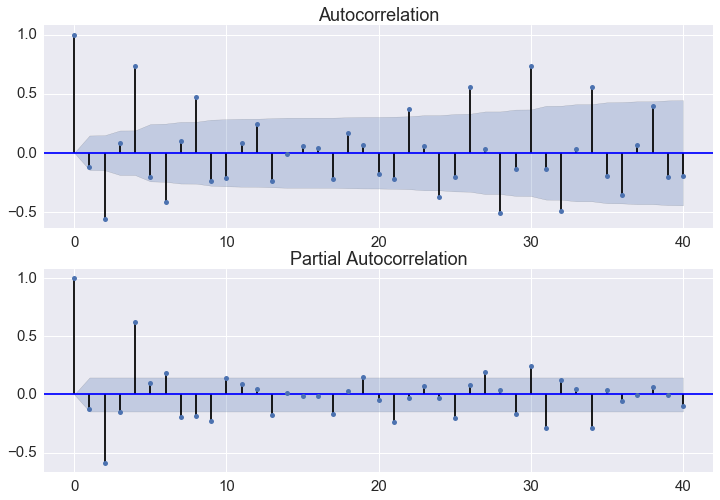

In [201]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(old_1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(old_1, lags=40, ax=ax2)
# plt.tight_layout()
# plt.savefig('/Final_Report/original_twinkle_ACF.png')

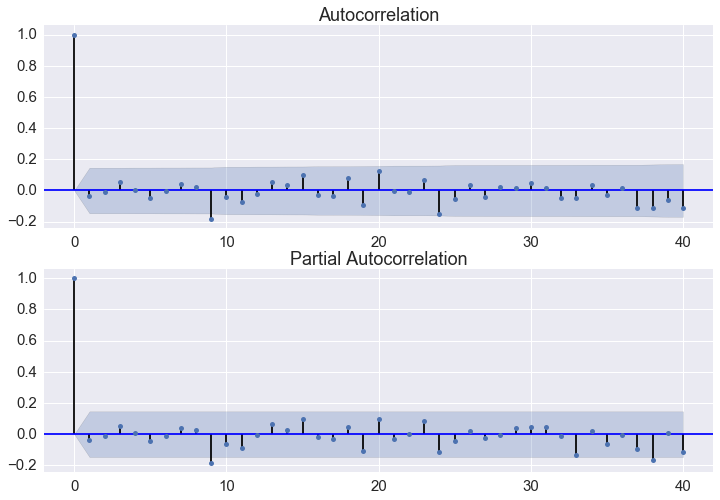

In [196]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_GAM, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_GAM, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('/Final_Report/GAM_twinkle_ACF.png')

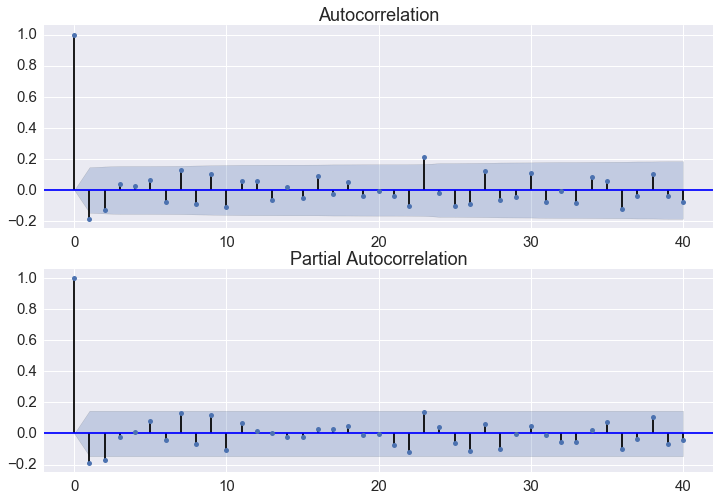

In [199]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_1, lags=40, ax=ax2)

In [273]:
_, _, _, _, _, _, _, _, Bach_fac = process_metrics('metrics/book2-fugue07__factorial_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_F = process_metrics('metrics/book2-fugue07__FHMMFactorizedVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_Gibbs = process_metrics('metrics/book2-fugue07__FHMMGibbs_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_S = process_metrics('metrics/book2-fugue07__FHMMStructuralVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_1 = process_metrics('metrics/book2-fugue07__first_order_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_GAM = process_metrics('metrics/book2-fugue07-TEST__GAMGaussian_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_lay = process_metrics('metrics/book2-fugue07__layered_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Bach_rand = process_metrics('metrics/book2-fugue07__random_5-tol0.01.csv')

_, _, _, _, _, _, _, _, Jup_fac = process_metrics('metrics/Jupiter__factorial_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_F = process_metrics('metrics/Jupiter__FHMMFactorizedVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_Gibbs = process_metrics('metrics/Jupiter__FHMMGibbs_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_S = process_metrics('metrics/Jupiter__FHMMStructuralVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_1 = process_metrics('metrics/Jupiter__first_order_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_GAM = process_metrics('metrics/Jupiter__GAMGaussian_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_lay = process_metrics('metrics/Jupiter__layered_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Jup_rand = process_metrics('metrics/Jupiter__random_5-tol0.01.csv')


_, _, _, _, _, _, _, _, Ode_fac = process_metrics('metrics/ode-to-joy__factorial_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_F = process_metrics('metrics/ode-to-joy__FHMMFactorizedVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_Gibbs = process_metrics('metrics/ode-to-joy__FHMMGibbs_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_S = process_metrics('metrics/ode-to-joy__FHMMStructuralVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_1 = process_metrics('metrics/ode-to-joy__first_order_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_GAM = process_metrics('metrics/ode-to-joy__GAMGaussian_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_lay = process_metrics('metrics/ode-to-joy__layered_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Ode_rand = process_metrics('metrics/ode-to-joy__random_5-tol0.01.csv')


_, _, _, _, _, _, _, _, pach_fac = process_metrics('metrics/pachelbel__factorial_5-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_F = process_metrics('metrics/pachelbel__FHMMFactorizedVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_Gibbs = process_metrics('metrics/pachelbel__FHMMGibbs_3-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_S = process_metrics('metrics/pachelbel__FHMMStructuralVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_1 = process_metrics('metrics/pachelbel__first_order_5-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_GAM = process_metrics('metrics/pachelbel-TEST__GAMGaussian_3-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_lay = process_metrics('metrics/pachelbel__layered_5-tol0.01.csv')
_, _, _, _, _, _, _, _, pach_rand = process_metrics('metrics/pachelbel__random_5-tol0.01.csv')


_, _, _, _, _, _, _, _, Twinkle_fac = process_metrics('metrics/twinkle-twinkle-little-star__factorial_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_F = process_metrics('metrics/twinkle-twinkle-little-star__FHMMFactorizedVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_Gibbs = process_metrics('metrics/twinkle-twinkle-little-star__FHMMGibbs_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_S = process_metrics('metrics/twinkle-twinkle-little-star__FHMMStructuralVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_1 = process_metrics('metrics/twinkle-twinkle-little-star__first_order_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_GAM = process_metrics('metrics/twinkle-twinkle-little-star__GAMGaussian_3-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_lay = process_metrics('metrics/twinkle-twinkle-little-star__layered_5-tol0.01.csv')
_, _, _, _, _, _, _, _, Twinkle_rand = process_metrics('metrics/twinkle-twinkle-little-star__random_5-tol0.01.csv')


_, _, _, _, _, _, _, _, West_fac = process_metrics('metrics/westworld__factorial_5-tol0.01.csv')
_, _, _, _, _, _, _, _, West_F = process_metrics('metrics/westworld__FHMMFactorizedVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, West_Gibbs = process_metrics('metrics/westworld__FHMMGibbs_3-tol0.01.csv')
_, _, _, _, _, _, _, _, West_S = process_metrics('metrics/westworld__FHMMStructuralVI_3-tol0.01.csv')
_, _, _, _, _, _, _, _, West_1 = process_metrics('metrics/westworld__first_order_5-tol0.01.csv')
_, _, _, _, _, _, _, _, West_GAM = process_metrics('metrics/westworld__GAMGaussian_3-tol0.01.csv')
_, _, _, _, _, _, _, _, West_lay = process_metrics('metrics/westworld__layered_5-tol0.01.csv')
_, _, _, _, _, _, _, _, West_rand = process_metrics('metrics/westworld__random_5-tol0.01.csv')


(1001, 153)
(1001, 153)
(1001, 153)
(1001, 153)
(1001, 153)
(1001, 153)
(1001, 153)
(1001, 153)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 157)
(1001, 157)
(1001, 157)
(1001, 157)
(1001, 157)
(1001, 157)
(1001, 157)
(1001, 157)


### Bach

In [274]:
metrics_Bach = pd.concat([Bach_1, Bach_rand, Bach_fac, Bach_lay, Bach_Gibbs, Bach_F, Bach_S, Bach_GAM])
metrics_Bach.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 
                      "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"]
print(metrics_Bach.round(3).to_latex())
metrics_Bach.round(3)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &  h\_ints &   m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    3.170 &        0.353 &  0.870 &  85.942 &  170.635 &    0.119 &        0.005 &  0.100 &  0.059 \\
Random                &    3.587 &        0.428 &  0.926 &  90.394 &  181.423 &    0.125 &        0.022 &  0.122 &  0.067 \\
Independent Factorial &    3.079 &        0.524 &  0.871 &  62.857 &  162.630 &    0.154 &        0.018 &  0.046 &  0.047 \\
Layered               &    3.182 &        0.404 &  0.845 &  78.619 &  155.151 &    0.113 &        0.004 &  0.081 &  0.056 \\
FHMM-Gibbs            &    3.420 &        0.401 &  0.903 &  89.663 &  180.746 &    0.128 &        0.016 &  0.119 &  0.066 \\
FHMM-Factorized VI    &    3.365 &        0.384 &  0.900 &  87.145 &  180.686 &    0.130 &        0.015 &  0.118 &  0.064 \\
FHMM-Structured VI    &    3.412 &        0.392 &  0.904 &  85.625 &  180.335 &    0.131 &    

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,3.170,0.353,0.870,85.942,170.635,0.119,0.005,0.100,0.059
Random,3.587,0.428,0.926,90.394,181.423,0.125,0.022,0.122,0.067
Independent Factorial,3.079,0.524,0.871,62.857,162.630,0.154,0.018,0.046,0.047
Layered,3.182,0.404,0.845,78.619,155.151,0.113,0.004,0.081,0.056
FHMM-Gibbs,3.420,0.401,0.903,89.663,180.746,0.128,0.016,0.119,0.066
FHMM-Factorized VI,3.365,0.384,0.900,87.145,180.686,0.130,0.015,0.118,0.064
FHMM-Structured VI,3.412,0.392,0.904,85.625,180.335,0.131,0.016,0.112,0.060
FHMM-GAM,2.088,0.132,0.896,48.143,117.022,0.175,0.035,0.122,0.067


In [312]:
pd.concat([metrics_Bach.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Bach.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose()

,First Order,Random,Independent Factorial,Layered,FHMM-Gibbs,FHMM-Factorized VI,FHMM-Structured VI,FHMM-GAM
entropy,6.0,1.0,7.0,5.0,2.0,4.0,3.0,8.0
edit,7.0,1.0,6.0,8.0,3.0,4.0,2.0,5.0
mutual_info,2.0,7.0,8.0,6.0,5.0,3.0,4.0,1.0
h_ints,5.0,8.0,2.0,3.0,7.0,6.0,4.0,1.0
m_ints,4.0,8.0,3.0,2.0,7.0,6.0,5.0,1.0
percent,2.0,3.0,7.0,1.0,4.0,5.0,6.0,8.0
note_counts,2.0,7.0,6.0,1.0,4.0,3.0,5.0,8.0
acf,3.0,8.0,1.0,2.0,6.0,5.0,4.0,7.0
pacf,3.0,8.0,1.0,2.0,6.0,5.0,4.0,7.0


### Jupiter

In [275]:
metrics_Jup = pd.concat([Jup_1, Jup_rand, Jup_fac, Jup_lay, Jup_Gibbs, Jup_F, Jup_S, Jup_GAM])
metrics_Jup.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 
                      "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"]
print(metrics_Jup.round(3).to_latex())
metrics_Jup.round(3)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &  h\_ints &  m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    3.054 &        0.281 &  0.843 &  39.867 &  58.693 &    0.172 &        0.005 &  0.088 &  0.073 \\
Random                &    3.235 &        0.305 &  0.895 &  40.590 &  59.999 &    0.173 &        0.023 &  0.100 &  0.086 \\
Independent Factorial &    2.822 &        0.674 &  0.811 &  38.496 &  56.214 &    0.179 &        0.023 &  0.053 &  0.055 \\
Layered               &    3.055 &        0.833 &  0.804 &  39.991 &  58.994 &    0.172 &        0.005 &  0.097 &  0.082 \\
FHMM-Gibbs            &    3.067 &        0.282 &  0.873 &  40.055 &  58.790 &    0.171 &        0.020 &  0.098 &  0.084 \\
FHMM-Factorized VI    &    3.038 &        0.286 &  0.868 &  40.249 &  58.873 &    0.172 &        0.019 &  0.098 &  0.083 \\
FHMM-Structured VI    &    2.921 &        0.260 &  0.860 &  39.772 &  57.708 &    0.174 &        0.01

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,3.054,0.281,0.843,39.867,58.693,0.172,0.005,0.088,0.073
Random,3.235,0.305,0.895,40.590,59.999,0.173,0.023,0.100,0.086
Independent Factorial,2.822,0.674,0.811,38.496,56.214,0.179,0.023,0.053,0.055
Layered,3.055,0.833,0.804,39.991,58.994,0.172,0.005,0.097,0.082
FHMM-Gibbs,3.067,0.282,0.873,40.055,58.790,0.171,0.020,0.098,0.084
FHMM-Factorized VI,3.038,0.286,0.868,40.249,58.873,0.172,0.019,0.098,0.083
FHMM-Structured VI,2.921,0.260,0.860,39.772,57.708,0.174,0.018,0.091,0.077
FHMM-GAM,1.315,0.052,0.922,43.990,42.686,0.246,0.056,0.100,0.086


### Ode to Joy

In [276]:
metrics_Ode = pd.concat([Ode_1, Ode_rand, Ode_fac, Ode_lay, Ode_Gibbs, Ode_F, Ode_S, Ode_GAM])
metrics_Ode.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 
                      "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"]
print(metrics_Ode.round(3).to_latex())
metrics_Ode.round(3)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &  h\_ints &  m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    2.316 &        0.169 &  0.696 &  20.634 &  39.372 &    0.134 &        0.009 &  0.141 &  0.107 \\
Random                &    2.674 &        0.190 &  0.840 &  21.004 &  42.832 &    0.141 &        0.056 &  0.142 &  0.107 \\
Independent Factorial &    2.422 &        0.626 &  0.738 &  19.959 &  40.860 &    0.146 &        0.056 &  0.108 &  0.087 \\
Layered               &    2.311 &        0.808 &  0.613 &  20.639 &  39.454 &    0.135 &        0.008 &  0.142 &  0.107 \\
FHMM-Gibbs            &    2.607 &        0.186 &  0.829 &  20.639 &  41.735 &    0.139 &        0.051 &  0.142 &  0.108 \\
FHMM-Factorized VI    &    2.462 &        0.179 &  0.804 &  20.706 &  40.799 &    0.141 &        0.041 &  0.140 &  0.106 \\
FHMM-Structured VI    &    2.527 &        0.187 &  0.785 &  20.761 &  41.705 &    0.141 &        0.03

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,2.316,0.169,0.696,20.634,39.372,0.134,0.009,0.141,0.107
Random,2.674,0.190,0.840,21.004,42.832,0.141,0.056,0.142,0.107
Independent Factorial,2.422,0.626,0.738,19.959,40.860,0.146,0.056,0.108,0.087
Layered,2.311,0.808,0.613,20.639,39.454,0.135,0.008,0.142,0.107
FHMM-Gibbs,2.607,0.186,0.829,20.639,41.735,0.139,0.051,0.142,0.108
FHMM-Factorized VI,2.462,0.179,0.804,20.706,40.799,0.141,0.041,0.140,0.106
FHMM-Structured VI,2.527,0.187,0.785,20.761,41.705,0.141,0.039,0.141,0.107
FHMM-GAM,1.694,0.095,0.894,18.198,24.654,0.163,0.091,0.142,0.107


### Pachelbel's Canon

In [277]:
metrics_pach = pd.concat([pach_1, pach_rand, pach_fac, pach_lay, pach_Gibbs, pach_F, pach_S, pach_GAM])
metrics_pach.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 
                      "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"]
print(metrics_pach.round(3).to_latex())
metrics_pach.round(3)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &  h\_ints &   m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    3.115 &        0.337 &  0.874 &  62.689 &   96.887 &    0.175 &        0.007 &  0.104 &  0.089 \\
Random                &    3.257 &        0.351 &  0.904 &  66.033 &  102.204 &    0.176 &        0.020 &  0.123 &  0.102 \\
Independent Factorial &    2.926 &        0.667 &  0.822 &  53.939 &   88.177 &    0.182 &        0.022 &  0.083 &  0.071 \\
Layered               &    3.125 &        0.416 &  0.850 &  58.866 &   92.455 &    0.163 &        0.006 &  0.099 &  0.094 \\
FHMM-Gibbs            &    3.151 &        0.342 &  0.891 &  65.026 &  100.509 &    0.172 &        0.020 &  0.120 &  0.100 \\
FHMM-Factorized VI    &    3.038 &        0.323 &  0.886 &  63.992 &   99.288 &    0.177 &        0.021 &  0.118 &  0.098 \\
FHMM-Structured VI    &    3.176 &        0.346 &  0.892 &  64.543 &   99.639 &    0.176 &    

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,3.115,0.337,0.874,62.689,96.887,0.175,0.007,0.104,0.089
Random,3.257,0.351,0.904,66.033,102.204,0.176,0.020,0.123,0.102
Independent Factorial,2.926,0.667,0.822,53.939,88.177,0.182,0.022,0.083,0.071
Layered,3.125,0.416,0.850,58.866,92.455,0.163,0.006,0.099,0.094
FHMM-Gibbs,3.151,0.342,0.891,65.026,100.509,0.172,0.020,0.120,0.100
FHMM-Factorized VI,3.038,0.323,0.886,63.992,99.288,0.177,0.021,0.118,0.098
FHMM-Structured VI,3.176,0.346,0.892,64.543,99.639,0.176,0.017,0.115,0.091
FHMM-GAM,2.004,0.129,0.904,45.251,60.561,0.192,0.046,0.122,0.102


### Twinkle, Twinkle

In [278]:
metrics_Twinkle = pd.concat([Twinkle_1, Twinkle_rand, Twinkle_fac, Twinkle_lay, Twinkle_Gibbs, 
                             Twinkle_F, Twinkle_S, Twinkle_GAM])
metrics_Twinkle.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 
                      "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"]
print(metrics_Twinkle.round(3).to_latex())
metrics_Twinkle.round(3)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &  h\_ints &  m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    2.321 &        0.399 &  0.746 &  11.690 &  12.587 &    0.098 &        0.031 &  0.244 &  0.222 \\
Random                &    2.409 &        0.385 &  0.828 &  13.138 &  14.101 &    0.107 &        0.048 &  0.245 &  0.223 \\
Independent Factorial &    2.279 &        1.235 &  0.612 &  13.201 &  14.035 &    0.107 &        0.047 &  1.932 &  3.827 \\
Layered               &    2.376 &        0.882 &  0.722 &  12.566 &  13.729 &    0.097 &        0.019 &  0.197 &  0.206 \\
FHMM-Gibbs            &    2.351 &        0.377 &  0.806 &  12.897 &  13.533 &    0.099 &        0.044 &  0.246 &  0.223 \\
FHMM-Factorized VI    &    2.208 &        0.330 &  0.805 &  13.145 &  13.208 &    0.111 &        0.051 &  0.245 &  0.222 \\
FHMM-Structured VI    &    2.394 &        0.402 &  0.760 &  12.653 &  13.956 &    0.099 &        0.03

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,2.321,0.399,0.746,11.690,12.587,0.098,0.031,0.244,0.222
Random,2.409,0.385,0.828,13.138,14.101,0.107,0.048,0.245,0.223
Independent Factorial,2.279,1.235,0.612,13.201,14.035,0.107,0.047,1.932,3.827
Layered,2.376,0.882,0.722,12.566,13.729,0.097,0.019,0.197,0.206
FHMM-Gibbs,2.351,0.377,0.806,12.897,13.533,0.099,0.044,0.246,0.223
FHMM-Factorized VI,2.208,0.330,0.805,13.145,13.208,0.111,0.051,0.245,0.222
FHMM-Structured VI,2.394,0.402,0.760,12.653,13.956,0.099,0.032,0.224,0.205
FHMM-GAM,2.296,0.365,0.805,13.084,13.462,0.103,0.049,0.245,0.223


In [279]:
metrics_Twinkle.rank(axis = 0).transpose()[["Random", "FHMM-Gibbs", "FHMM-Factorized VI", 
                                           "FHMM-Structured VI", "FHMM-GAM"]]

,Random,FHMM-Gibbs,FHMM-Factorized VI,FHMM-Structured VI,FHMM-GAM
entropy,8.0,5.0,1.0,7.0,3.0
mutual_info,4.0,3.0,1.0,6.0,2.0
edit,8.0,7.0,5.0,4.0,6.0
h_ints,6.0,4.0,7.0,3.0,5.0
m_ints,8.0,4.0,2.0,6.0,3.0
percent,6.0,4.0,8.0,3.0,5.0
note_counts,6.0,4.0,8.0,3.0,7.0
acf,5.0,7.0,4.0,2.0,6.0
pacf,5.0,7.0,3.0,1.0,6.0


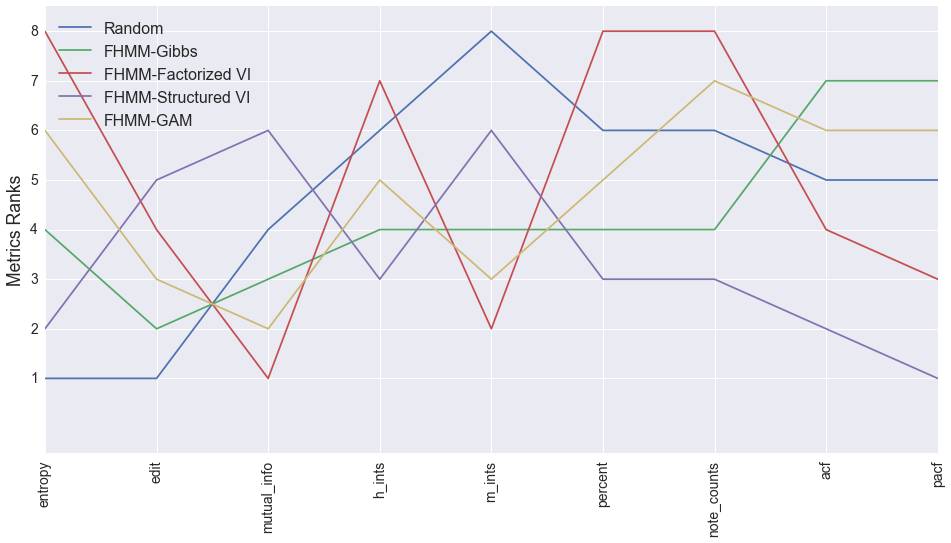

In [307]:
plt.figure(figsize = (16,8))
pd.concat([metrics_Twinkle.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Twinkle.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose()[["Random", "FHMM-Gibbs", "FHMM-Factorized VI", 
                                           "FHMM-Structured VI", "FHMM-GAM"]].plot(ylim = [-0.5, 8.5], 
                                                                                   yticks = np.arange(1, 9),
                                                                                  fontsize = 14, rot = 90,
                                                                                  figsize = (16,8))
ax.set_ylim(-0.5, 8.5)
ax.set_yticks(np.arange(1, 9))
plt.ylabel("Metrics Ranks")
# plt.tight_layout()
# plt.savefig('Final_Report/Figures/first-order_twinkle_ACF.png')
pass

In [227]:
Tr = metrics_Twinkle.rank(axis = 0)
Tr["piece"] = "Twinkle, Twinkle"
Pr = metrics_pach.rank(axis = 0)
Pr["piece"] = "Pachelbel"
Tr.append(Pr)

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf,piece
First Order,4.0,5.0,3.0,1.0,1.0,2.0,2.0,3.0,4.0,"Twinkle, Twinkle"
Random,8.0,4.0,8.0,6.0,8.0,6.0,6.0,5.0,5.0,"Twinkle, Twinkle"
Independent Factorial,2.0,8.0,1.0,8.0,7.0,7.0,5.0,8.0,8.0,"Twinkle, Twinkle"
Layered,6.0,7.0,2.0,2.0,5.0,1.0,1.0,1.0,2.0,"Twinkle, Twinkle"
FHMM-Gibbs,5.0,3.0,7.0,4.0,4.0,4.0,4.0,7.0,7.0,"Twinkle, Twinkle"
FHMM-Factorized VI,1.0,1.0,5.0,7.0,2.0,8.0,8.0,4.0,3.0,"Twinkle, Twinkle"
FHMM-Structured VI,7.0,6.0,4.0,3.0,6.0,3.0,3.0,2.0,1.0,"Twinkle, Twinkle"
FHMM-GAM,3.0,2.0,6.0,5.0,3.0,5.0,7.0,6.0,6.0,"Twinkle, Twinkle"
First Order,4.0,3.0,3.0,4.0,4.0,3.0,2.0,3.0,2.0,Pachelbel
Random,8.0,6.0,7.0,8.0,8.0,4.0,5.0,8.0,8.0,Pachelbel


In [296]:
metrics_Twinkle.drop(["entropy", "edit"], axis = 1).rank(axis = 0)

,mutual_info,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,5.0,1.0,1.0,2.0,2.0,3.0,4.0
Random,4.0,6.0,8.0,6.0,6.0,5.0,5.0
Independent Factorial,8.0,8.0,7.0,7.0,5.0,8.0,8.0
Layered,7.0,2.0,5.0,1.0,1.0,1.0,2.0
FHMM-Gibbs,3.0,4.0,4.0,4.0,4.0,7.0,7.0
FHMM-Factorized VI,1.0,7.0,2.0,8.0,8.0,4.0,3.0
FHMM-Structured VI,6.0,3.0,6.0,3.0,3.0,2.0,1.0
FHMM-GAM,2.0,5.0,3.0,5.0,7.0,6.0,6.0


In [299]:
pd.concat([metrics_Twinkle.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Twinkle.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], axis = 1)

,entropy,edit,mutual_info,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,5.0,6.0,5.0,1.0,1.0,2.0,2.0,3.0,4.0
Random,1.0,1.0,4.0,6.0,8.0,6.0,6.0,5.0,5.0
Independent Factorial,7.0,8.0,8.0,8.0,7.0,7.0,5.0,8.0,8.0
Layered,3.0,7.0,7.0,2.0,5.0,1.0,1.0,1.0,2.0
FHMM-Gibbs,4.0,2.0,3.0,4.0,4.0,4.0,4.0,7.0,7.0
FHMM-Factorized VI,8.0,4.0,1.0,7.0,2.0,8.0,8.0,4.0,3.0
FHMM-Structured VI,2.0,5.0,6.0,3.0,6.0,3.0,3.0,2.0,1.0
FHMM-GAM,6.0,3.0,2.0,5.0,3.0,5.0,7.0,6.0,6.0


In [334]:
data1.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]
data1

,First Order,Random,Ind. Fact.,Layered,FHMM-Gibbs,FHMM-FVI,FHMM-SVI,FHMM-GAM,Piece
entropy,5.0,1.0,7.0,3.0,4.0,8.0,2.0,6.0,"Twinkle, Twinkle"
edit,6.0,1.0,8.0,7.0,2.0,4.0,5.0,3.0,"Twinkle, Twinkle"
mutual_info,5.0,4.0,8.0,7.0,3.0,1.0,6.0,2.0,"Twinkle, Twinkle"
h_ints,1.0,6.0,8.0,2.0,4.0,7.0,3.0,5.0,"Twinkle, Twinkle"
m_ints,1.0,8.0,7.0,5.0,4.0,2.0,6.0,3.0,"Twinkle, Twinkle"
percent,2.0,6.0,7.0,1.0,4.0,8.0,3.0,5.0,"Twinkle, Twinkle"
note_counts,2.0,6.0,5.0,1.0,4.0,8.0,3.0,7.0,"Twinkle, Twinkle"
acf,3.0,5.0,8.0,1.0,7.0,4.0,2.0,6.0,"Twinkle, Twinkle"
pacf,4.0,5.0,8.0,2.0,7.0,3.0,1.0,6.0,"Twinkle, Twinkle"


In [335]:
# data1 = metrics_Twinkle.rank(axis = 0).transpose().assign(Piece = "Twinkle, Twinkle")
# data2 = metrics_pach.rank(axis = 0).transpose().assign(Piece = "Pachelbel")
# data3 = metrics_Bach.rank(axis = 0).transpose().assign(Piece = "Bach")


data1 = pd.concat([metrics_Twinkle.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Twinkle.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose().assign(Piece = "Twinkle, Twinkle")
data2 = pd.concat([metrics_pach.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_pach.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose().assign(Piece = "Pachelbel")
data3 = pd.concat([metrics_Bach.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Bach.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose().assign(Piece = "Bach")
data4 = pd.concat([metrics_Ode.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Ode.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose().assign(Piece = "Ode to Joy")
data5 = pd.concat([metrics_Jup.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_Jup.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose().assign(Piece = "Jupiter")
data6 = pd.concat([metrics_West.ix[:, ["entropy", "edit"]].rank(axis = 0, ascending = False), 
         metrics_West.drop(["entropy", "edit"], axis = 1).rank(axis = 0)], 
                  axis = 1).transpose().assign(Piece = "Westworld Theme")
data1.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]
data2.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]
data3.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]
data4.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]
data5.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]
data6.columns = ['First Order', 'Random', "Ind. Fact.", "Layered", "FHMM-Gibbs", "FHMM-FVI", "FHMM-SVI", "FHMM-GAM", 
                "Piece"]


cdf = pd.concat([data1, data2, data3])    
# cdf = pd.concat([data1, data2, data3, data4, data5, data6])    
mdf = pd.melt(cdf, id_vars=['Piece'], var_name=['Model'])
print(mdf.head())

              Piece        Model  value
0  Twinkle, Twinkle  First Order    5.0
1  Twinkle, Twinkle  First Order    6.0
2  Twinkle, Twinkle  First Order    5.0
3  Twinkle, Twinkle  First Order    1.0
4  Twinkle, Twinkle  First Order    1.0


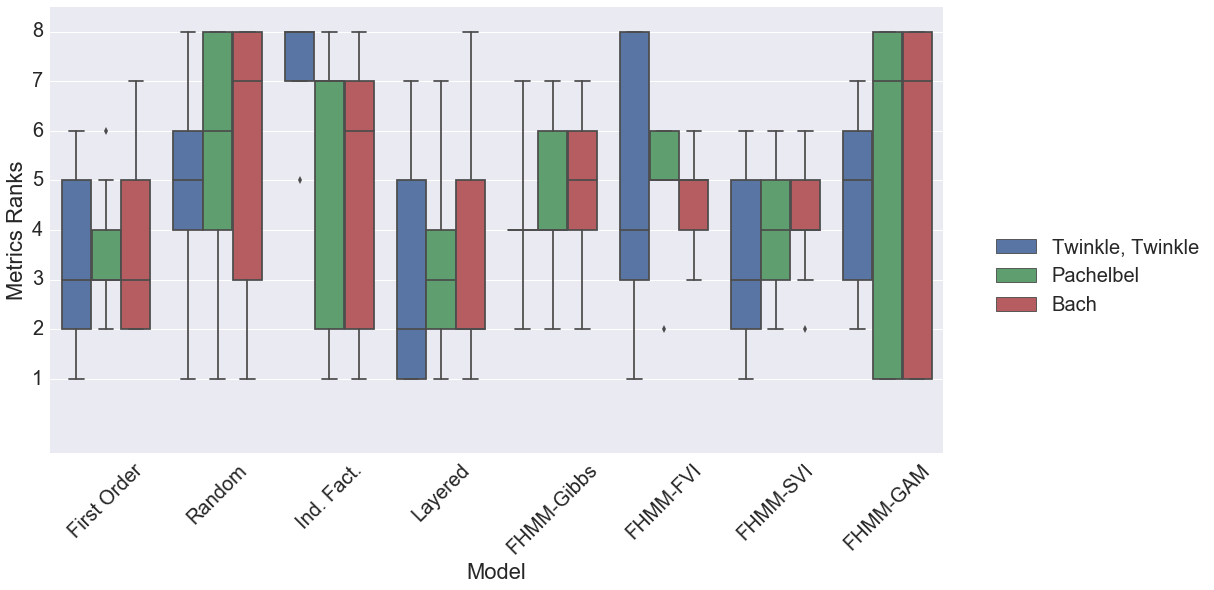

In [336]:
sns.set(font_scale=2)
plt.figure(figsize = (16,8))
ax = sns.boxplot(x="Model", y="value", hue="Piece", data=mdf)
ax.set_ylim(-0.5, 8.5)
ax.set_yticks(np.arange(1, 9))
ax.set_ylabel("Metrics Ranks")
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
#plt.tight_layout()
plt.savefig('Final_Report/Figures/metrics_ranks.png', bbox_inches="tight")
plt.show()

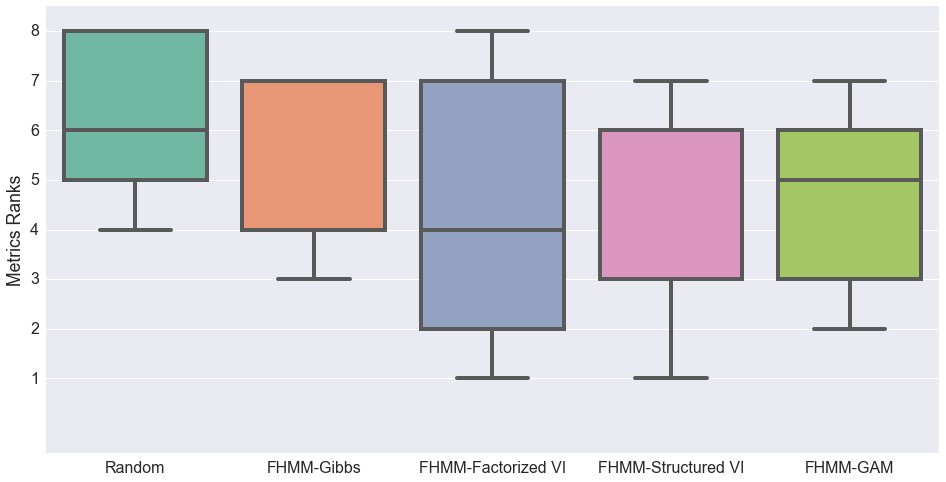

In [248]:
plt.figure(figsize = (16,8))
sns.set(font_scale=1.6)
ax = sns.boxplot(data = metrics_Twinkle.rank(axis = 0).transpose()[["Random", "FHMM-Gibbs", "FHMM-Factorized VI", 
                                           "FHMM-Structured VI", "FHMM-GAM"]],  palette="Set2", linewidth = 4)
ax.set_ylim(-0.5, 8.5)
ax.set_yticks(np.arange(1, 9))
ax.set_ylabel("Metrics Ranks")
pass





# plt.tight_layout()
# plt.savefig('Final_Report/Figures/first-order_twinkle_ACF.png')

In [ ]:
f, axarr = plt.subplots(2, sharex=True)
f.suptitle('Sharing X axis')
axarr[0].plot(x, y)
axarr[1].scatter(x, y)

/Users/annayanchenko/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


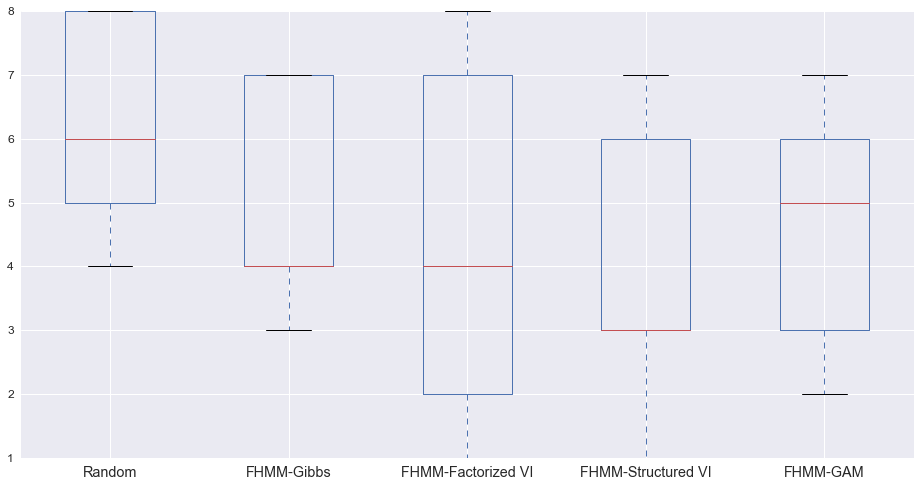

In [224]:
plt.figure(figsize = (16,8))
# metrics_Twinkle.rank(axis = 0).transpose()[["Random", "FHMM-Gibbs", "FHMM-Factorized VI", 
#                                            "FHMM-Structured VI", "FHMM-GAM"]].plot(ylim = [-0.5, 8.5], 
#                                                                                    yticks = np.arange(1, 9),
#                                                                                   fontsize = 14, rot = 90, kind = 'box',
#                                                                                   patch_artist=True,
#                                                                                   figsize = (16,8),
#                                                                                   colormap='viridis')
metrics_Twinkle.rank(axis = 0).transpose()[["Random", "FHMM-Gibbs", "FHMM-Factorized VI", 
                                           "FHMM-Structured VI", "FHMM-GAM"]].boxplot()
pass

### Westworld Theme

In [134]:
metrics_West = pd.concat([West_1, West_rand, West_fac, West_lay, West_Gibbs, West_F, West_S, West_GAM])
metrics_West.index = ['First Order', 'Random', 'Independent Factorial', 'Layered', 
                      "FHMM-Gibbs", "FHMM-Factorized VI", "FHMM-Structured VI", "FHMM-GAM"]
print(metrics_West.round(3).to_latex())
metrics_West.round(3)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  entropy &  mutual\_info &   edit &   h\_ints &   m\_ints &  percent &  note\_counts &    acf &   pacf \\
\midrule
First Order           &    3.228 &        0.528 &  0.884 &   95.995 &  138.293 &    0.384 &        0.005 &  0.172 &  0.090 \\
Random                &    3.686 &        0.618 &  0.949 &  109.057 &  155.333 &    0.400 &        0.021 &  0.177 &  0.093 \\
Independent Factorial &    3.217 &        0.781 &  0.871 &   80.364 &  136.067 &    0.410 &        0.021 &  0.070 &  0.068 \\
Layered               &    3.236 &        1.068 &  0.777 &   79.294 &  110.181 &    0.355 &        0.004 &  0.173 &  0.089 \\
FHMM-Gibbs            &    3.515 &        0.568 &  0.936 &  103.747 &  153.756 &    0.400 &        0.019 &  0.170 &  0.089 \\
FHMM-Factorized VI    &    3.444 &        0.546 &  0.933 &  101.681 &  153.446 &    0.401 &        0.019 &  0.175 &  0.091 \\
FHMM-Structured VI    &    2.370 &        0.427 &  0.974 &   97.991 &  133.428 &    0.3

,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,3.228,0.528,0.884,95.995,138.293,0.384,0.005,0.172,0.090
Random,3.686,0.618,0.949,109.057,155.333,0.400,0.021,0.177,0.093
Independent Factorial,3.217,0.781,0.871,80.364,136.067,0.410,0.021,0.070,0.068
Layered,3.236,1.068,0.777,79.294,110.181,0.355,0.004,0.173,0.089
FHMM-Gibbs,3.515,0.568,0.936,103.747,153.756,0.400,0.019,0.170,0.089
FHMM-Factorized VI,3.444,0.546,0.933,101.681,153.446,0.401,0.019,0.175,0.091
FHMM-Structured VI,2.370,0.427,0.974,97.991,133.428,0.399,0.037,0.118,0.083
FHMM-GAM,1.757,0.131,0.948,48.198,77.512,0.416,0.037,0.176,0.092


## Interpret Hidden States

In [135]:
orig_list = ['twinkle-twinkle-little-star-orig.csv']
new_list = ['twinkle-twinkle-little-star.csv']
quarter_note = [256]
M = 3
K = np.array([5, 5, 5])

for i in range(len(orig_list)):
    oldfile = 'OriginalCSV/' + orig_list[i]
    newfile = 'NewCSV/interpret__' + new_list[i]
    _, _, timeT, notes, newNotes_G, params_G = FHMM_compose(oldfile, newfile, quarter_note[i], 
                                                                      "FHMM", "Gibbs", None, 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("Gibbs Done")
    _, _, timeT, notes, newNotes_F, params_F = FHMM_compose(oldfile, newfile, quarter_note[i], 
                                                                      "FHMM", "FactorizedVI", None, 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("Factorized Done")
    _, _, timeT, notes, newNotes_S, params_S = FHMM_compose(oldfile, newfile, quarter_note[i], 
                                                                          "FHMM", "StructuralVI", None, 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("Structural Done")
    _, _, timeT, notes, newNotes_GAM, params_GAM = FHMM_compose(oldfile, newfile, 
                                                                               quarter_note[i], "GAM", "Gaussian", "V", 
                                                 M, K, 0.01, 1000, metrics_calc = False)
    print("GAM V Done")
    
    _, _, _, old_1, newNotes_1, z_1, phi_1, Tmat_1 = hmm_compose(oldfile, newfile, quarter_note[i], 'first_order', 
                                                         5, 0.01, 1000, None, metrics_calc = False)
   
    print(newfile)

1 180
[[ 1.]]
10
0.0916103979661
20
1.335292126
30
0.357088789697
40
1.22986263955
50
0.926552635174
60
0.639051889627
70
0.0891435593214
80
0.92340551456
90
0.12608113106
100
0.0116493694175
110
0.276053481733
120
0.390371496432
130
0.893942690777
140
0.260925951721
150
0.546354717681
160
0.289593115366
170
0.054693861298
180
1.37040406331
190
0.36673642706
200
0.0160969411397
210
0.137022647569
220
0.00779804405279
[ 60.  69.  48.  60.  41.  52.  69.  52.  48.  55.  60.  55.  60.  62.  60.
  55.  52.  55.  48.  60.  52.  69.  57.  52.  62.  64.  48.  64.  55.  48.
  60.  60.  52.  55.  52.  69.  55.  62.  60.  65.  67.  60.  64.  67.  62.
  57.  48.  48.  67.  55.  65.  57.  48.  52.  43.  69.  69.  55.  60.  48.
  64.  57.  52.  62.  69.  48.  55.  67.  57.  67.  62.  43.  41.  48.  60.
  69.  41.  69.  55.  65.  57.  60.  67.  65.  69.  48.  69.  55.  52.  41.
  48.  55.  60.  65.  52.  55.  52.  62.  43.  65.  69.  55.  60.  67.  55.
  67.  52.  60.  41.  52.  48.  65.  52.  60.  

In [150]:
np.unique(notes)

array([41, 43, 48, 52, 55, 57, 60, 62, 64, 65, 67, 69])

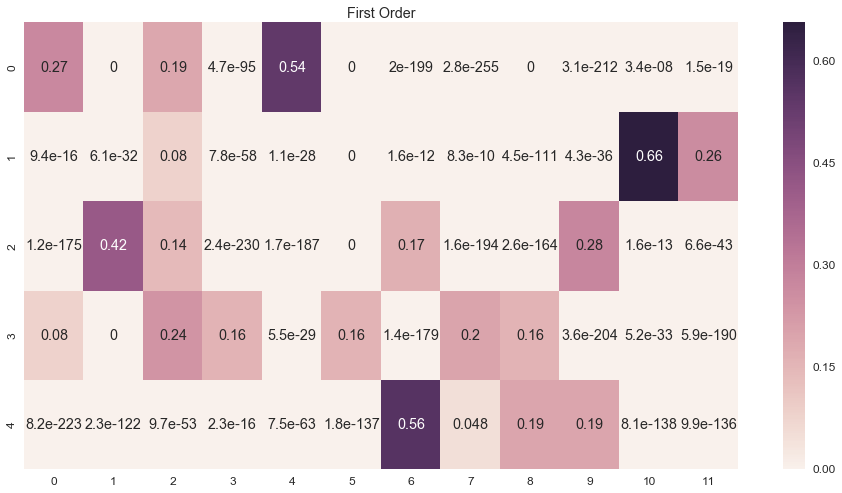

In [151]:
import seaborn as sns
plt.figure(figsize = (16, 8))
plt.title("First Order")
sns.set(font_scale=1.2)
axs = sns.heatmap(phi_1, annot=True)

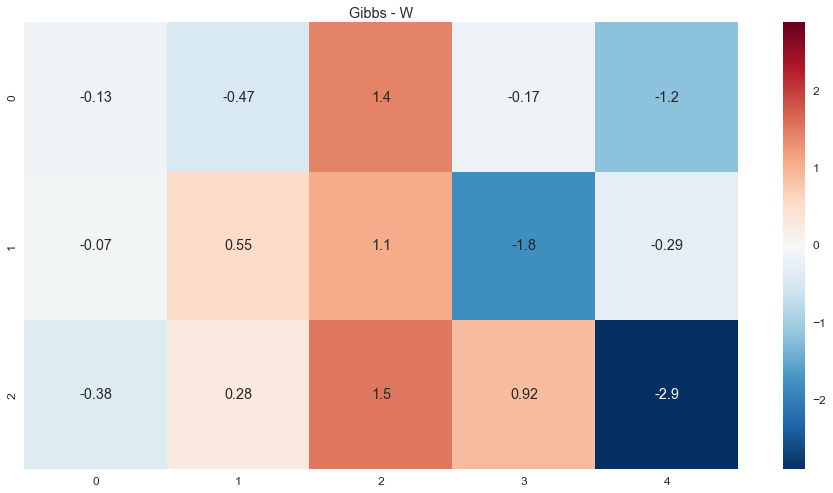

In [164]:
plt.figure(figsize = (16, 8))
plt.title("Gibbs - W")
axs = sns.heatmap(pd.DataFrame([i[0] for i  in params_G[3]]), annot=True)

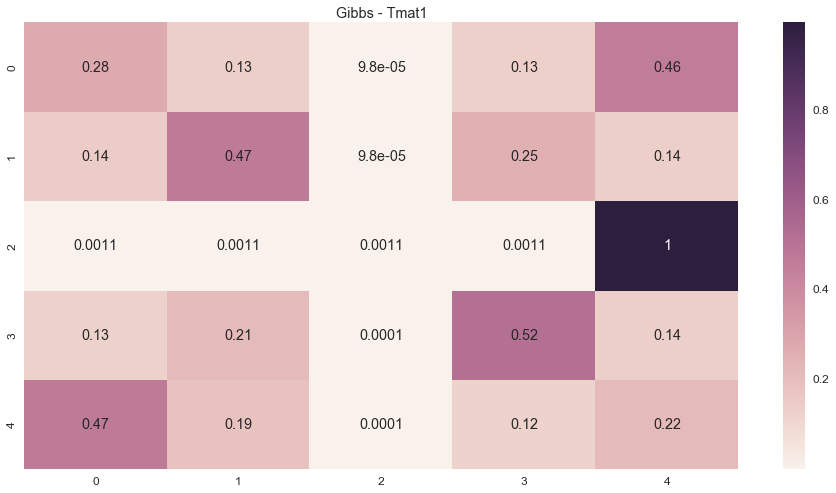

In [153]:
# params_G
# params = [pi, Tmat, C_new, W]

plt.figure(figsize = (16, 8))
plt.title("Gibbs - Tmat1")
axs = sns.heatmap(params_G[1][0], annot=True)

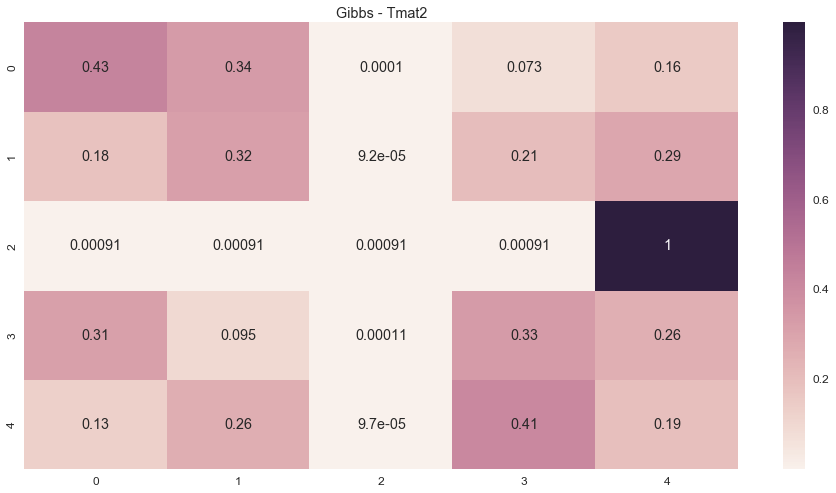

In [154]:
plt.figure(figsize = (16, 8))
plt.title("Gibbs - Tmat2")
axs = sns.heatmap(params_G[1][1], annot=True)

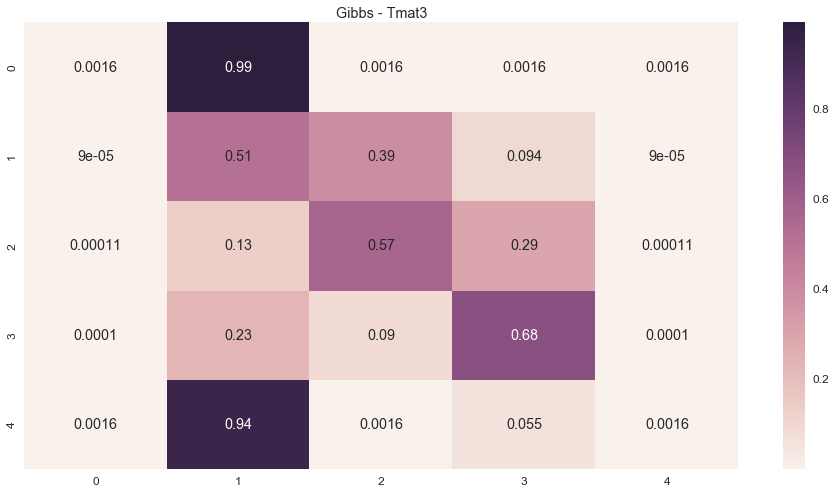

In [155]:
plt.figure(figsize = (16, 8))
plt.title("Gibbs - Tmat3")
axs = sns.heatmap(params_G[1][2], annot=True)

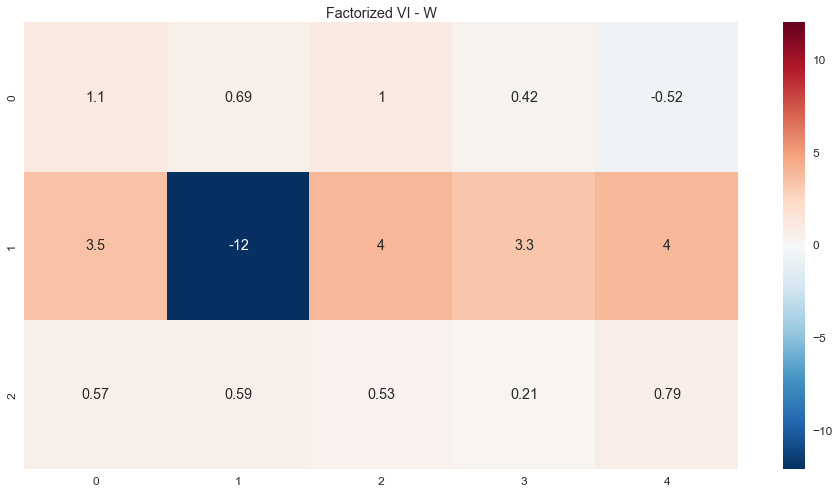

In [165]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - W")
axs = sns.heatmap(pd.DataFrame([i[0] for i  in params_F[3]]), annot=True)

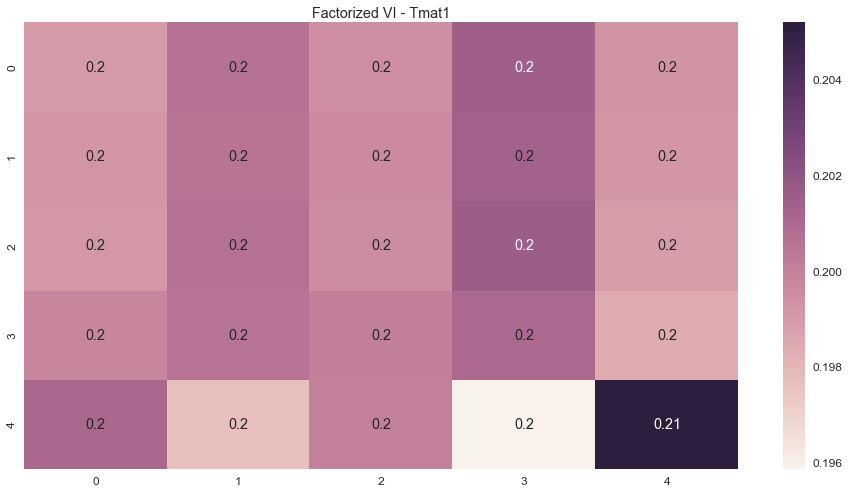

In [166]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - Tmat1")
axs = sns.heatmap(params_F[1][0], annot=True)

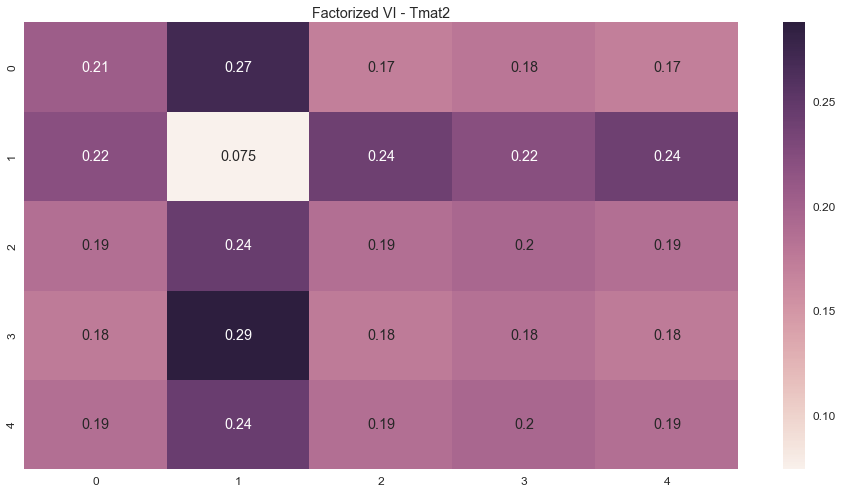

In [167]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - Tmat2")
axs = sns.heatmap(params_F[1][1], annot=True)

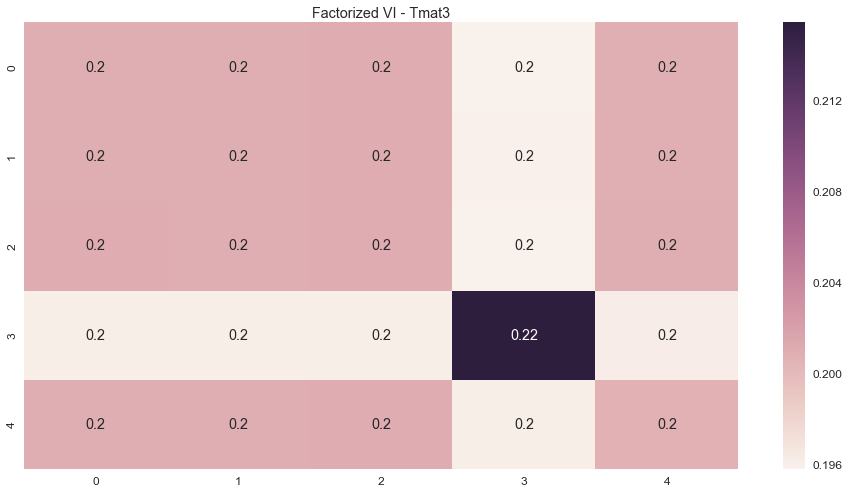

In [168]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - Tmat3")
axs = sns.heatmap(params_F[1][2], annot=True)

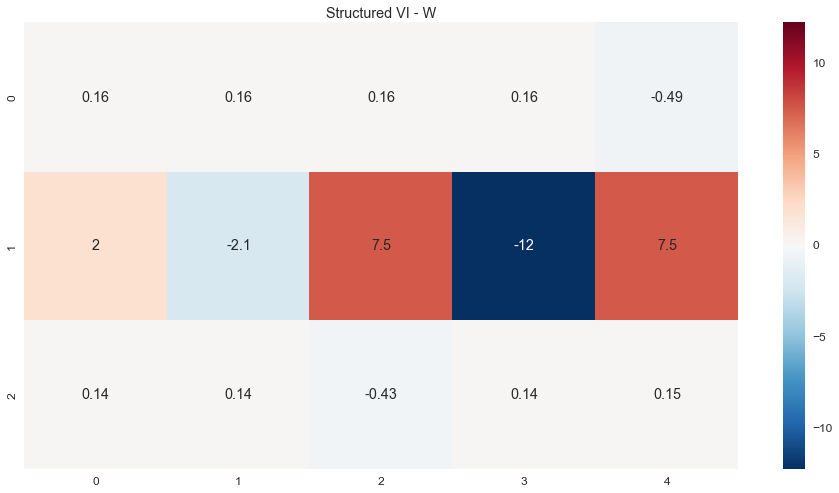

In [169]:
plt.figure(figsize = (16, 8))
plt.title("Structured VI - W")
axs = sns.heatmap(pd.DataFrame([i[0] for i  in params_S[3]]), annot=True)

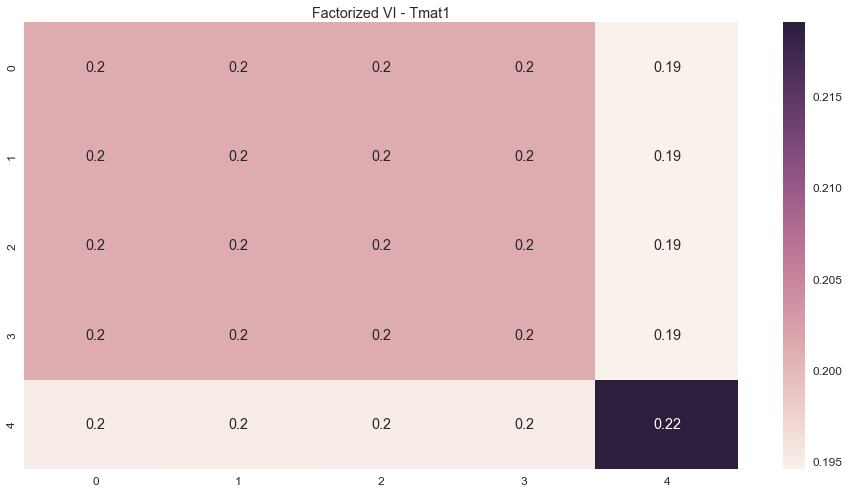

In [170]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - Tmat1")
axs = sns.heatmap(params_S[1][0], annot=True)

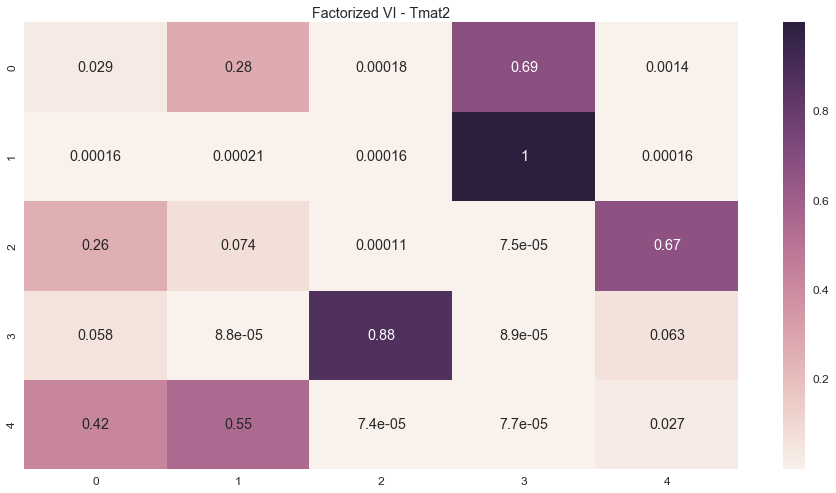

In [171]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - Tmat2")
axs = sns.heatmap(params_S[1][1], annot=True)

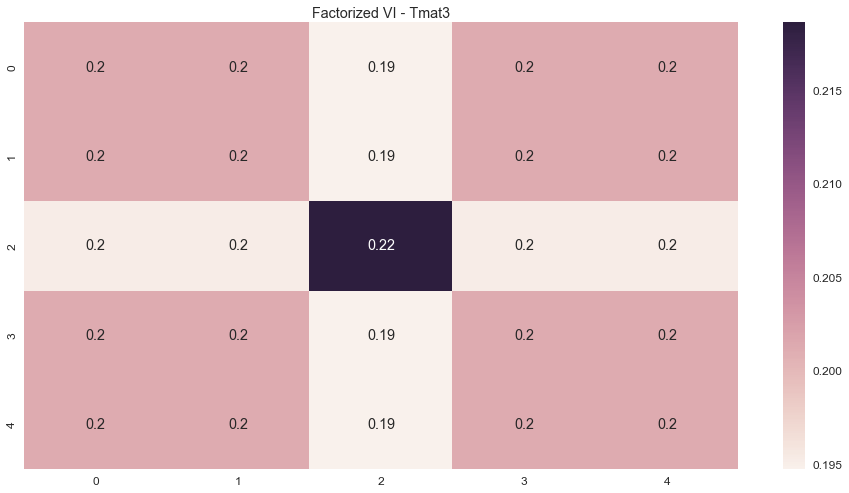

In [172]:
plt.figure(figsize = (16, 8))
plt.title("Factorized VI - Tmat3")
axs = sns.heatmap(params_S[1][2], annot=True)

In [180]:
params_GAM[3]

[array([-9.99288687, -9.98733392, -9.98569953, -9.98650251, -9.99829288]),
 array([ 4.94716177,  4.952715  ,  4.92139043,  4.94376279,  4.9370541 ]),
 array([ 5.05183891,  5.04114384,  5.06738776,  5.04486206,  5.05341183])]

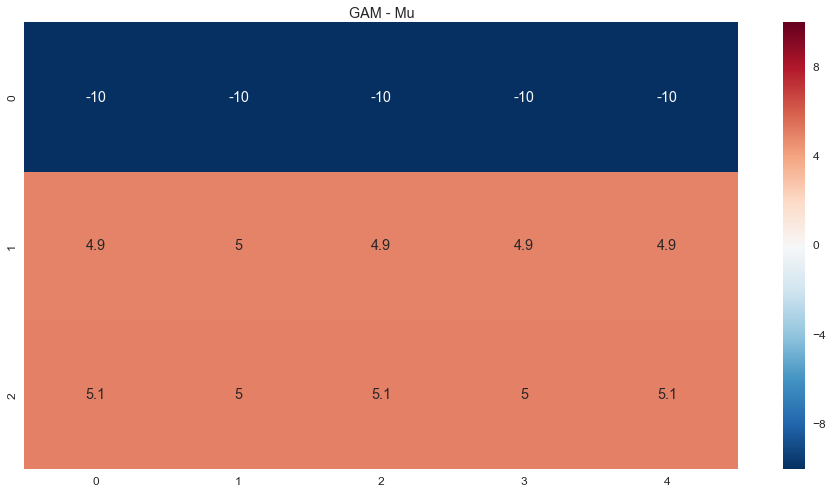

In [179]:
plt.figure(figsize = (16, 8))
plt.title("GAM - Mu")
axs = sns.heatmap(pd.DataFrame(params_GAM[3]), annot=True)

In [181]:
params_GAM[4]

[array([ 8.54434283,  8.5371002 ,  8.53426744,  8.541381  ,  8.5583536 ]),
 array([ 8.53903194,  8.53229532,  8.55831804,  8.54847612,  8.5186077 ]),
 array([ 8.53420677,  8.56009095,  8.50377322,  8.54510778,  8.55317399])]

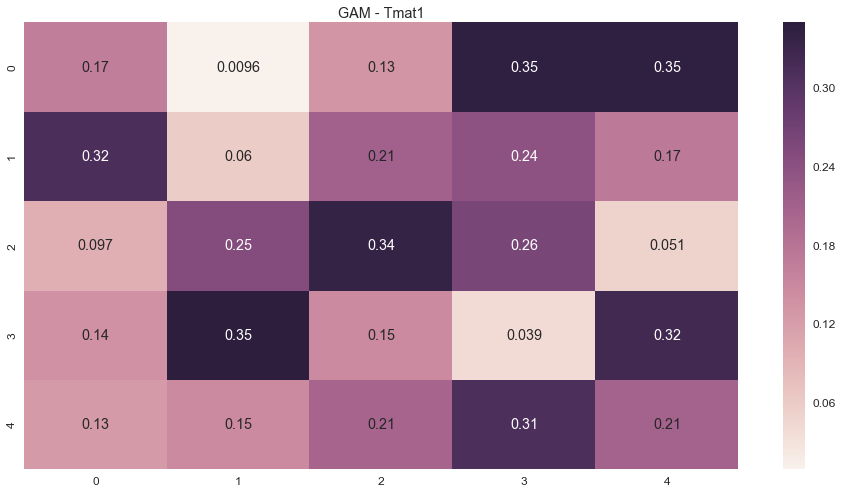

In [183]:
plt.figure(figsize = (16, 8))
plt.title("GAM - Tmat1")
axs = sns.heatmap(params_GAM[1][0], annot=True)

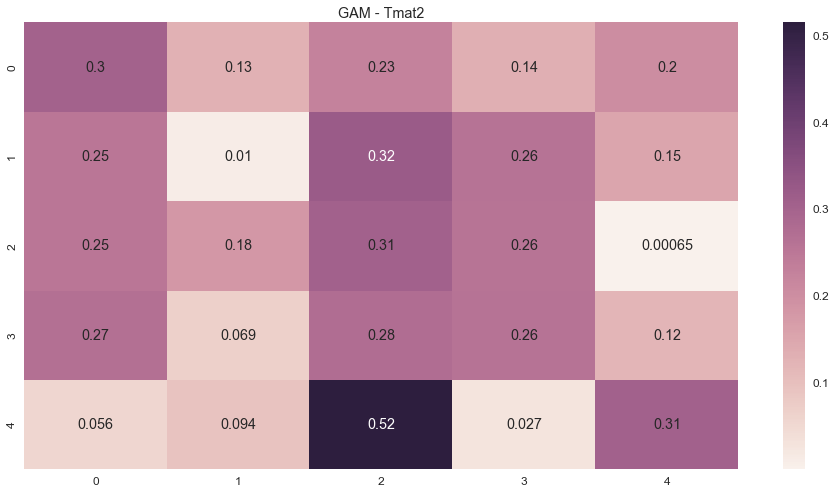

In [184]:
plt.figure(figsize = (16, 8))
plt.title("GAM - Tmat2")
axs = sns.heatmap(params_GAM[1][1], annot=True)

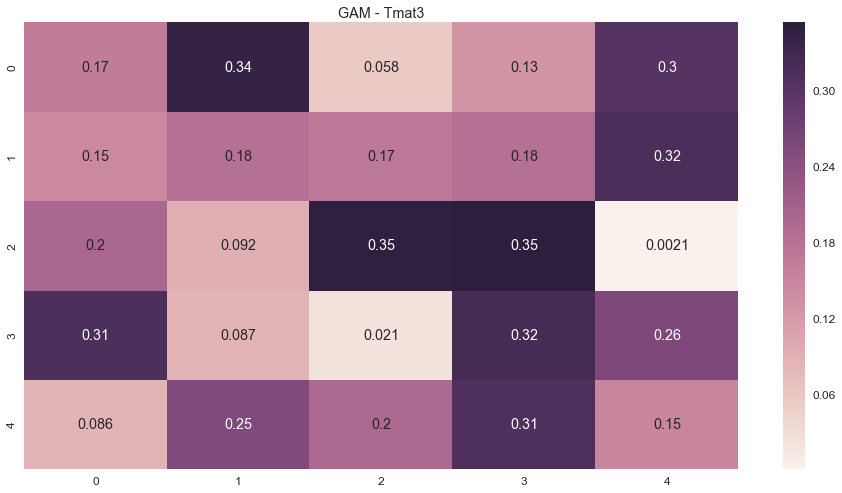

In [185]:
plt.figure(figsize = (16, 8))
plt.title("GAM - Tmat3")
axs = sns.heatmap(params_GAM[1][2], annot=True)

### ACF/PACF Plots

In [ ]:
# orig_list = ['twinkle-twinkle-little-star-orig.csv', 'book2-fugue07.csv', 
#             'beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'Jupiter.csv', 'pachelbel.csv',
#             'Ramin_Djawadi_-_Westworld_Theme.csv']
# new_list = ['twinkle-twinkle-little-star.csv', 'book2-fugue07.csv', 'ode-to-joy.csv', 'Jupiter.csv',
#            'pachelbel.csv', 'westworld.csv']
# quarter_note = [256, 64, 128, 64, 64, 80]

# it_1 = np.zeros(len(orig_list))
# elapsed_1 = np.zeros(len(orig_list))
# it_r = np.zeros(len(orig_list))
# elapsed_r = np.zeros(len(orig_list))
# it_lay = np.zeros(len(orig_list))
# elapsed_lay = np.zeros(len(orig_list))
# it_f = np.zeros(len(orig_list))
# elapsed_f = np.zeros(len(orig_list))

# for i in range(len(orig_list)):
#     oldfile = 'OriginalCSV/' + orig_list[i]
#     newfile = 'NewCSV/' + new_list[i]
#     it_1[i], elapsed_1[i], _, old_1, new_1, z_1, phi_1, Tmat_1 = hmm_compose(oldfile, newfile, 
#                                                                                 quarter_note[i], 'first_order', 
#                                                          5, 0.01, 1000, None, metrics_calc = True)
#     print("first order done")
#     it_r[i], elapsed_r[i], _, old_r, new_r, z_r, phi_r, Tmat_r = hmm_compose(oldfile, newfile, 
#                                                                                  quarter_note[i], 'random', 
#                                                          5, 0.01, 1000, None, metrics_calc = True)
#     print("random done")
#     it_lay[i], elapsed_lay[i], _, old_l, new_l, z_l, phi_l, Tmat_l = hmm_compose(oldfile, newfile, 
#                                                                                  quarter_note[i], 'layered', 
#                                                          5, 0.01, 1000, None, metrics_calc = True)
#     print("layered done")
#     it_f[i], elapsed_f[i], _, old_f, new_f, z_f, phi_f, Tmat_f = hmm_compose(oldfile, newfile, 
#                                                                                  quarter_note[i], 'factorial', 
#                                                          5, 0.01, 1000, None, metrics_calc = True)
#     print("factorial done")
#     print(newfile)

Original


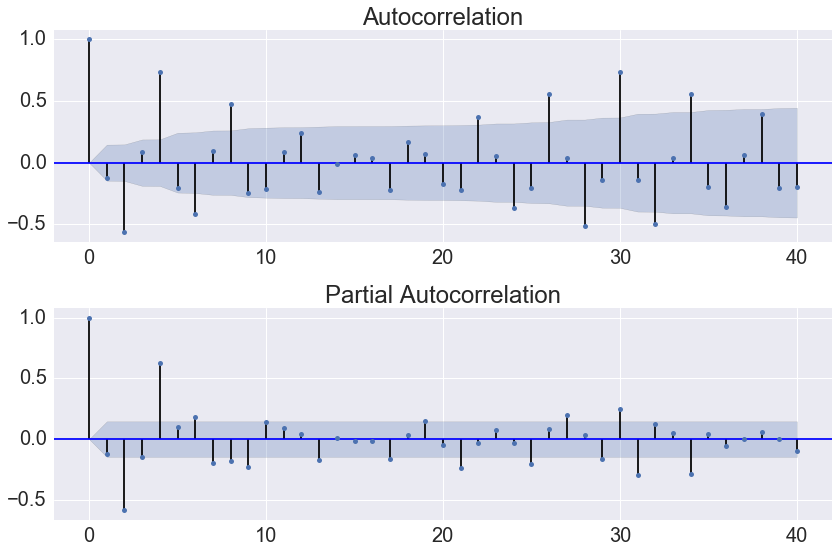

In [327]:
print("Original")
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(notes, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(notes, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('Final_Report/Figures/original_twinkle_ACF.png')

First Order


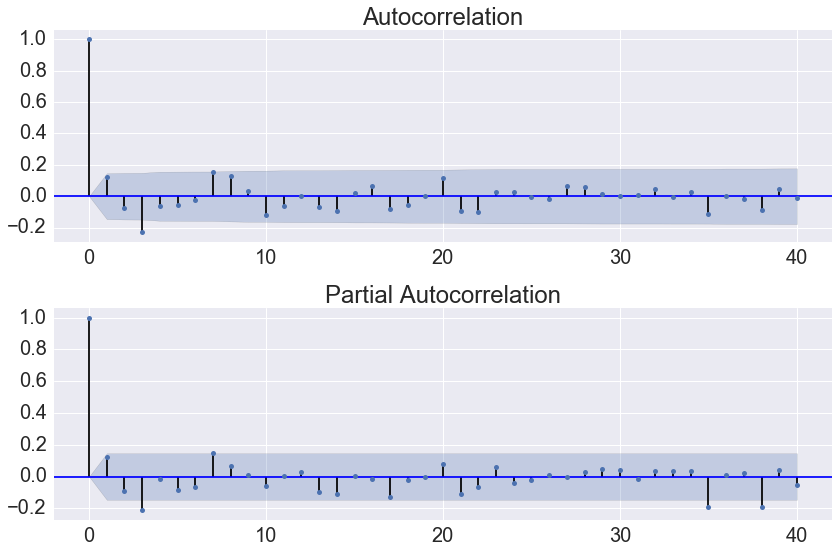

In [328]:
print("First Order")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_1, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('Final_Report/Figures/first-order_twinkle_ACF.png')

GAM


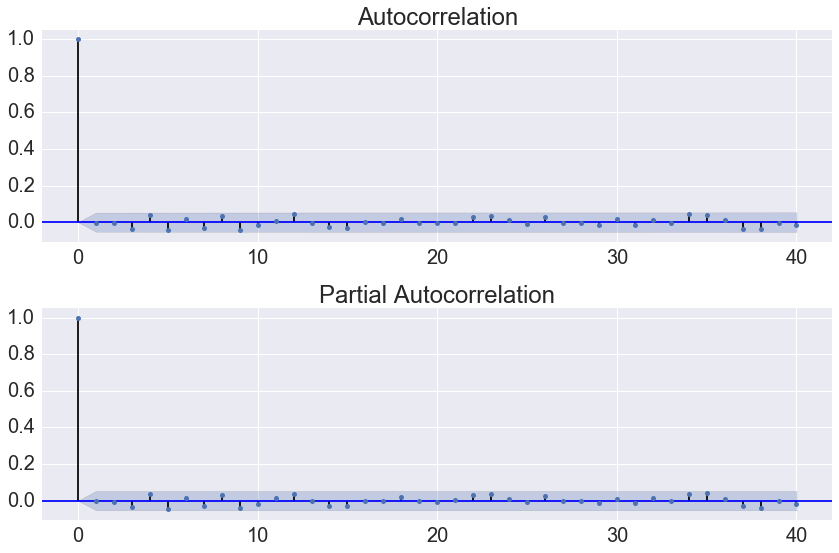

In [329]:
print("GAM")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_GAM, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_GAM, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('Final_Report/Figures/FHMM-GAM_twinkle_ACF.png')

Gibbs


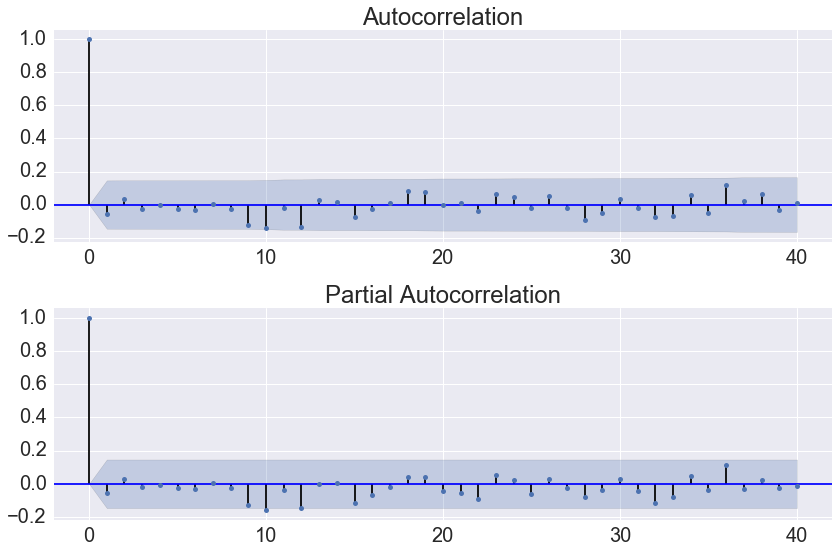

In [330]:
print("Gibbs")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_G, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_G, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('Final_Report/Figures/FHMM-Gibbs_twinkle_ACF.png')

Factorized VI


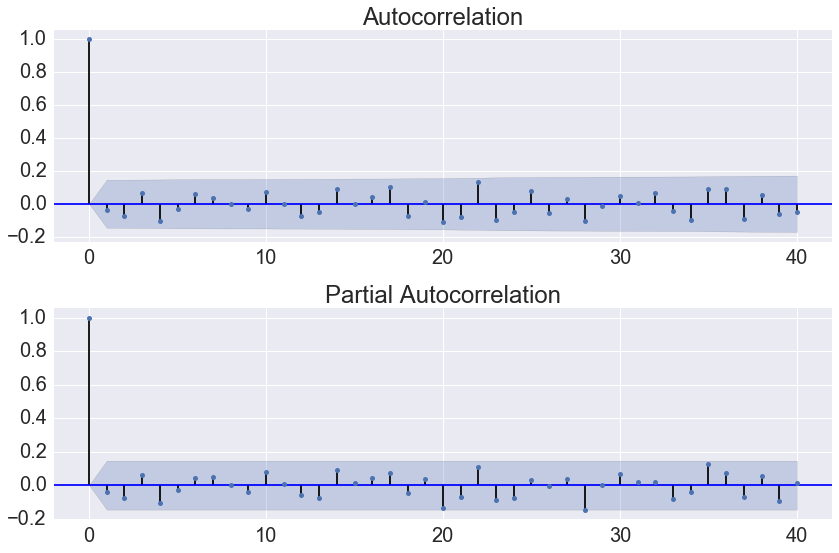

In [331]:
print("Factorized VI")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_F, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_F, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('Final_Report/Figures/FHMM-FactorizedVI_twinkle_ACF.png')

Structured VI


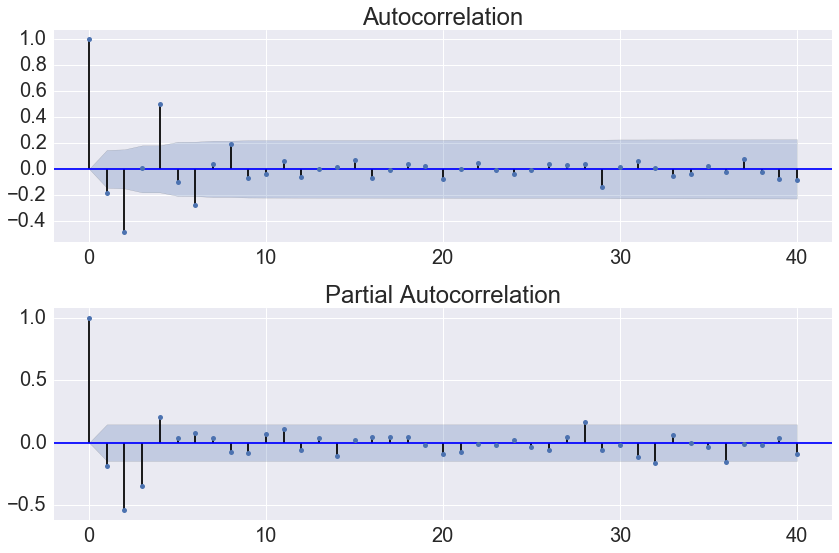

In [332]:
print("Structured VI")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_S, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_S, lags=40, ax=ax2)
plt.tight_layout()
plt.savefig('Final_Report/Figures/FHMM-StructuredVI_twinkle_ACF.png')

In [338]:
## Length of pieces
quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process("OriginalCSV/twinkle-twinkle-little-star-orig.csv", 
                                                     256).read_process()
print("Twinkle", len(notes))

Twinkle 180


In [339]:
quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process("OriginalCSV/pachelbel.csv", 
                                                     256).read_process()
print("Pachelbel", len(notes))

Pachelbel 1050


In [341]:
quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process("OriginalCSV/book2-fugue07.csv", 
                                                     256).read_process()
print("Bach", len(notes))

Bach 1408
